# Przygotowanie zbiorów danych

In [1]:
from src.prepare_datasets import prepare_dialogue_dataset

In [11]:
prepare_dialogue_dataset(100, 'data/dialogues/low_overlap', 'data/metadata_val.csv', min_speakers=2, max_speakers=5, min_fragments_per_speaker=1, max_fragments_per_speaker=3, min_speaker_time=8,
                        overlap_prob=0.15, min_overlap=1, max_overlap=8, allow_repeat_speakers=False,
                        min_space=0.5, max_space=1.5, sr=16000, seed=42)

100%|██████████| 100/100 [00:02<00:00, 39.42it/s]

Overlap time: 5.387280592078481 %


In [3]:
prepare_dialogue_dataset(100, 'data/dialogues/mid_overlap', 'data/metadata_val.csv', min_speakers=2, max_speakers=5, min_fragments_per_speaker=1, max_fragments_per_speaker=3, min_speaker_time=8,
                        overlap_prob=0.3, min_overlap=1, max_overlap=8, allow_repeat_speakers=False,
                        min_space=0.5, max_space=1.5, sr=16000, seed=42)

100%|██████████| 100/100 [00:06<00:00, 16.02it/s]

Overlap time: 10.582869908496702 %


In [5]:
prepare_dialogue_dataset(100, 'data/dialogues/high_overlap', 'data/metadata_val.csv', min_speakers=2, max_speakers=5, min_fragments_per_speaker=1, max_fragments_per_speaker=3, min_speaker_time=8,
                        overlap_prob=0.60, min_overlap=1, max_overlap=8, allow_repeat_speakers=False,
                        min_space=0.5, max_space=1.5, sr=16000, seed=42)

100%|██████████| 100/100 [00:05<00:00, 17.94it/s]

Overlap time: 21.248157997601606 %


# Testy narzędzi do overlapped speech detection

In [1]:
from pyannote.audio import Pipeline
from pyannote.audio import Model
from pyannote.audio.pipelines import OverlappedSpeechDetection
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("API_KEY")

model1 = Pipeline.from_pretrained("pyannote/overlapped-speech-detection", use_auth_token=API_KEY)
model2 = OverlappedSpeechDetection(Model.from_pretrained("pyannote/segmentation", use_auth_token=API_KEY))
model3 = OverlappedSpeechDetection(Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=API_KEY))

c:\Studia\.conda\Lib\inspect.py:988: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
c:\Studia\.conda\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\wikto\.cache\torch\pyannote\models--pyannote--seg

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\wikto\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\660b9e20307a2b0cdb400d0f80aadc04a701fc54\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


In [2]:
from tqdm import tqdm
import pandas as pd
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import json

In [12]:
def compute_overlap_times(ref_segments, pred_segments, total_time):
    events = []
    for start, end in ref_segments:
        events.append((start, 'start', 'ref'))
        events.append((end, 'end', 'ref'))
    for start, end in pred_segments:
        events.append((start, 'start', 'pred'))
        events.append((end, 'end', 'pred'))

    events.sort(key=lambda x: (x[0], x[1] == 'end'))

    prev_time = 0
    in_ref = False
    in_pred = False
    TP = FP = FN = TN = 0.0

    for time, kind, source in events:
        duration = time - prev_time

        if duration > 0:
            if in_ref and in_pred:
                TP += duration
            elif in_ref and not in_pred:
                FN += duration
            elif not in_ref and in_pred:
                FP += duration
            else:
                TN += duration

        if source == 'ref':
            in_ref = kind == 'start' if not in_ref else kind != 'end'
        elif source == 'pred':
            in_pred = kind == 'start' if not in_pred else kind != 'end'

        prev_time = time

    if prev_time < total_time:
        duration = total_time - prev_time
        if in_ref and in_pred:
            TP += duration
        elif in_ref and not in_pred:
            FN += duration
        elif not in_ref and in_pred:
            FP += duration
        else:
            TN += duration

    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}


def test_overlap_detection(model, datasets, n=100):
    all_results = {}
    for dataset in datasets:
        overlap_df = pd.read_csv(f'data/dialogues/{dataset}/overlaps.csv')
        results = []
        for i in range(n):
            wav = librosa.load(f'data/dialogues/{dataset}/{i}.wav', sr=16000)[0]
            pred_overlaps = model({"waveform": torch.Tensor(wav).unsqueeze(0), "sample_rate": 16000})
            pred_overlaps = [[overlap.start, overlap.end] for overlap in pred_overlaps.itersegments()]
            overlaps = [(row['start'], row['end']) for _, row in overlap_df[overlap_df['sample_id'] == i].iterrows()]
            scores = compute_overlap_times(overlaps, pred_overlaps, len(wav) / 16000)
            prec = scores['TP'] / (scores['TP'] + scores['FP']) if (scores['TP'] + scores['FP']) > 0 else 1 if scores['FN'] == 0 else 0
            rec = scores['TP'] / (scores['TP'] + scores['FN']) if (scores['TP'] + scores['FN']) > 0 else 1 if scores['FP'] == 0 else 0
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
            results.append([prec, rec, f1])
        results = list(np.mean(results, axis=0))
        all_results[dataset] = results
    return all_results


def test_params(args, param, values):
    datasets = ['low_overlap', 'mid_overlap', 'high_overlap']
    curr_model_names = ["overlapped-speech-detection", "segmentation", "segmentation-3.0"]
    if param == 'onset' or param == 'offset':
        curr_model_names = curr_model_names[:-1]
    results = {model: {dataset: [] for dataset in datasets} for model in curr_model_names}
    for value in tqdm(values):
        curr_args = args.copy()
        curr_args[param] = value

        model1.instantiate(curr_args)
        result = test_overlap_detection(model1, datasets, n=100)
        for dataset, metric in result.items():
            results["overlapped-speech-detection"][dataset].append(metric)
        
        model2.instantiate(curr_args)
        result = test_overlap_detection(model2, datasets, n=100)
        for dataset, metric in result.items():
            results["segmentation"][dataset].append(metric)

        if not (param == 'onset' or param == 'offset'):
            model3.instantiate({'min_duration_on': curr_args['min_duration_on'], 'min_duration_off': curr_args['min_duration_off']})
            result = test_overlap_detection(model3, datasets, n=100)
            for dataset, metric in result.items():
                results["segmentation-3.0"][dataset].append(metric)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    metric_names = ["precision", "recall", "f1_score"]

    for i, metric in enumerate(metric_names):
        for j, dataset in enumerate(datasets):
            axes[i, j].set_title(f"{metric} for {dataset} dataset")
            axes[i, j].set_xlabel(param)
            axes[i, j].set_ylabel(metric)
            axes[i, j].set_ylim(0, 1)
            for model in curr_model_names:
                axes[i, j].plot(values, [metrics[i] for metrics in results[model][dataset]], label=model)
            axes[i, j].legend()
    
    plt.tight_layout()
    plt.show()
    return results

In [2]:
standard_args = {
    "onset": 0.5,
    "offset": 0.5,
    "min_duration_on": 0,
    "min_duration_off": 0
}

100%|██████████| 10/10 [38:46<00:00, 232.67s/it]


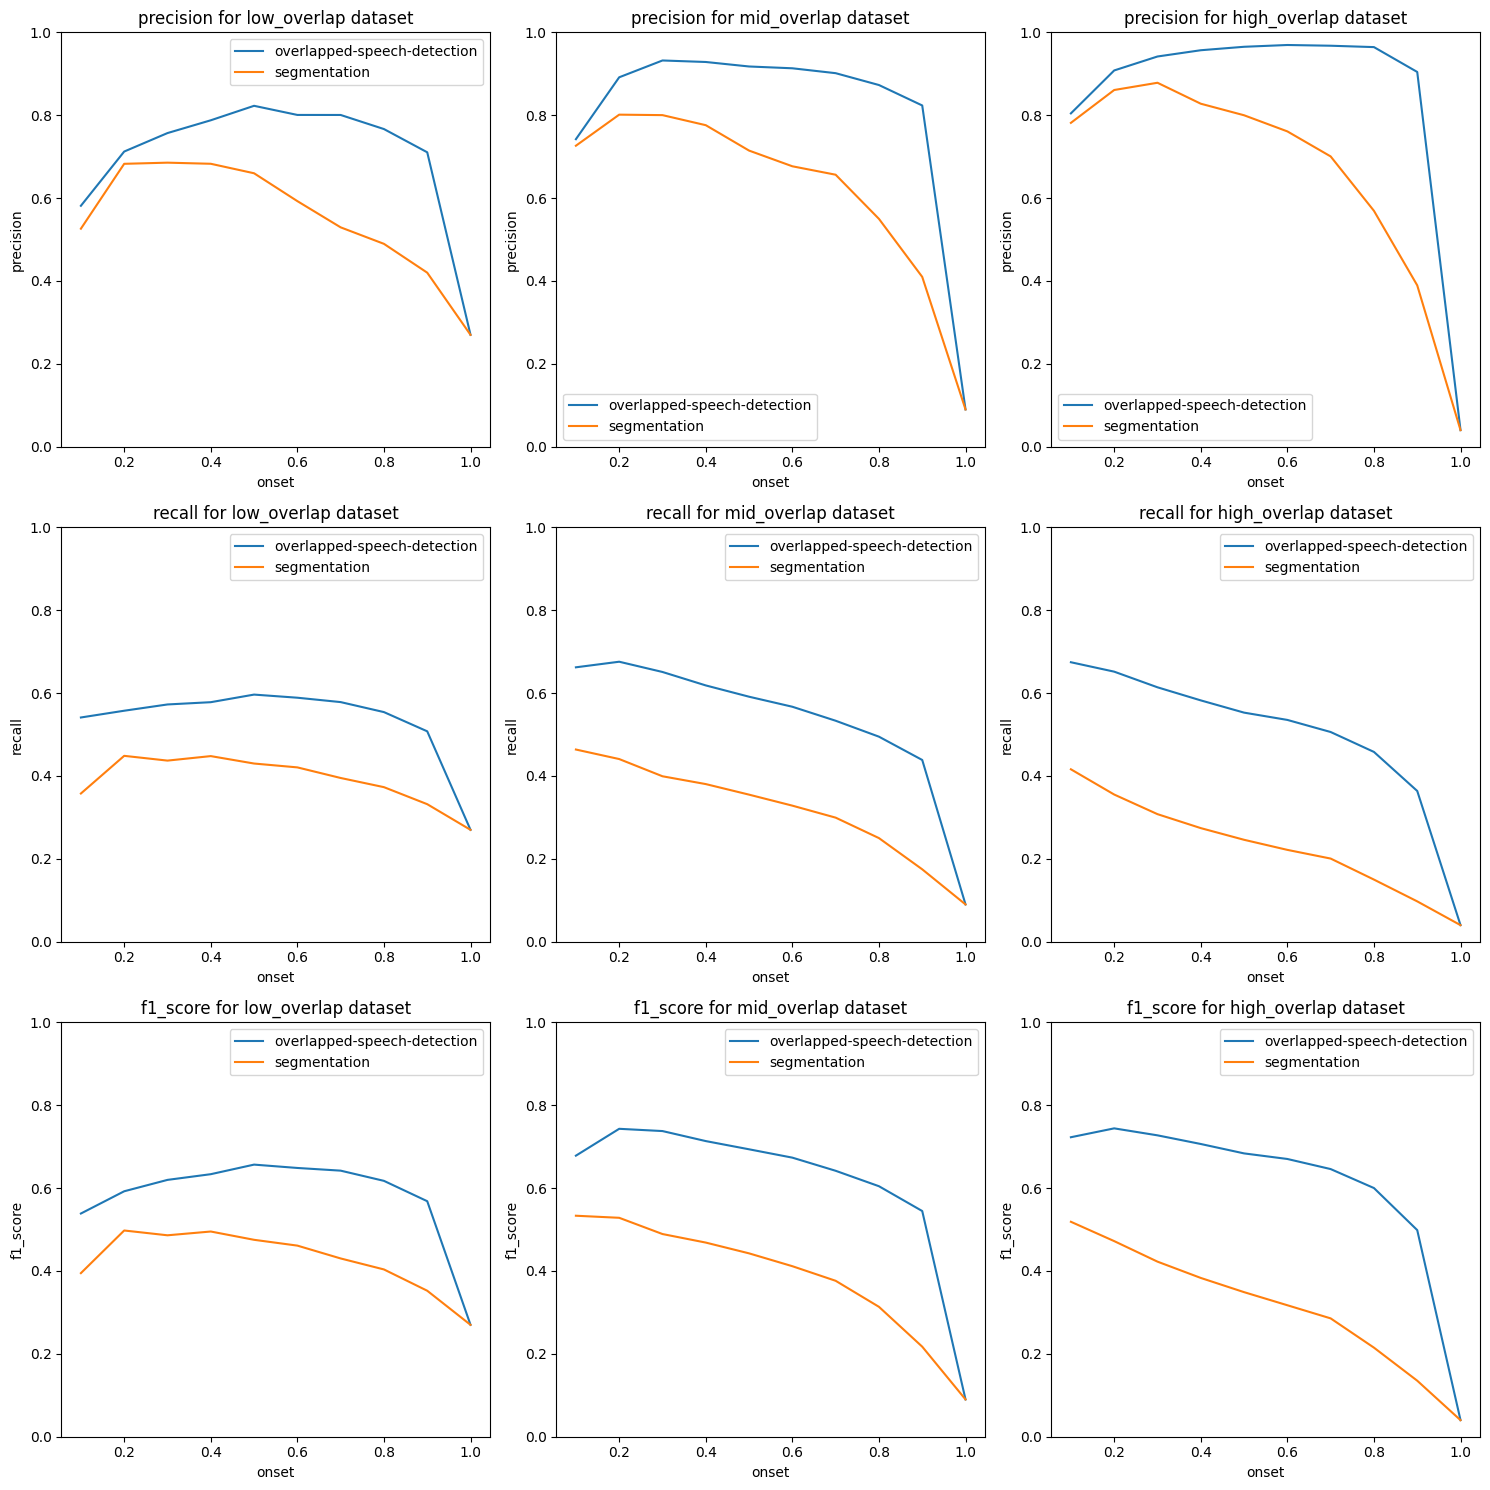

In [52]:
results = test_params(standard_args, "onset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/onset.json", "w"), indent=4)

100%|██████████| 10/10 [38:04<00:00, 228.45s/it]


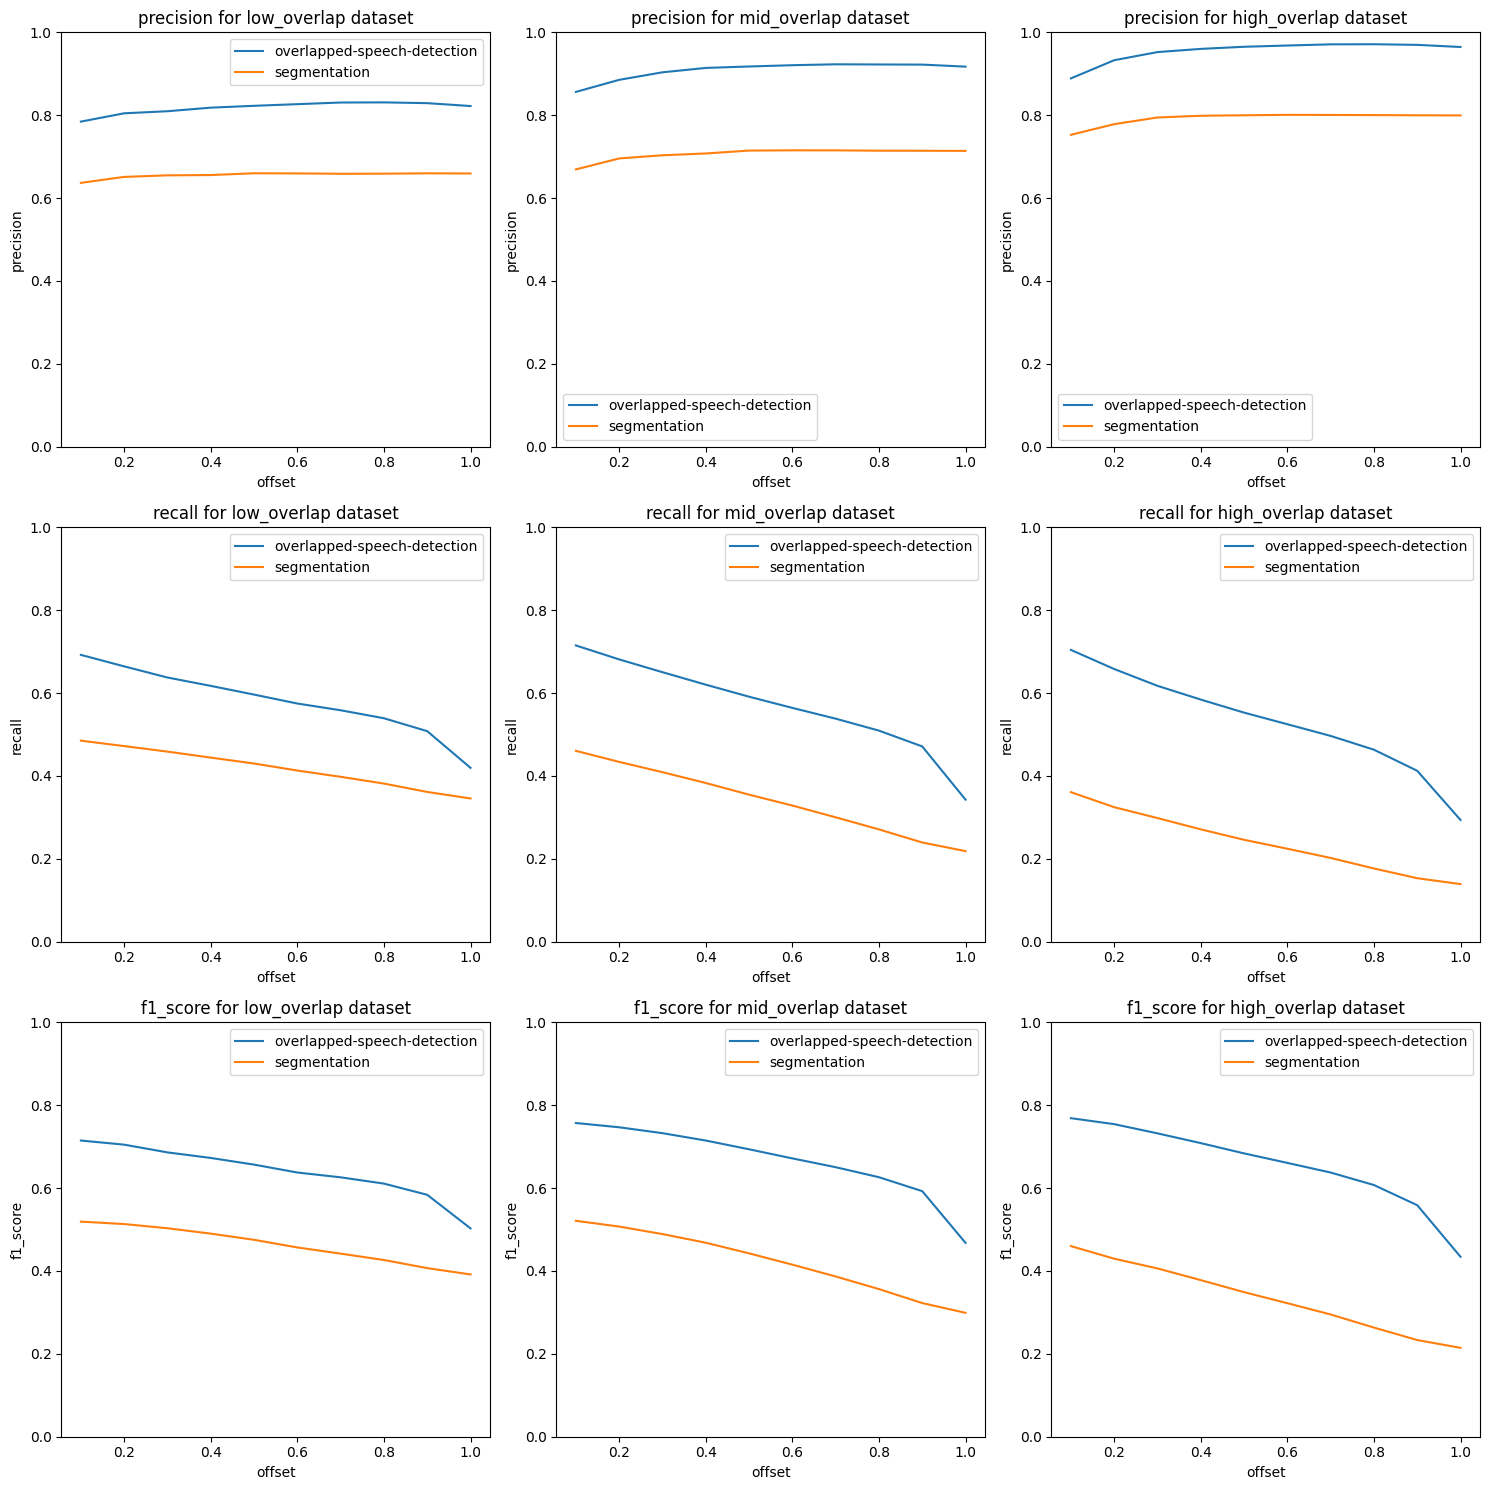

In [53]:
results = test_params(standard_args, "offset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/offset.json", "w"), indent=4)

100%|██████████| 11/11 [1:00:42<00:00, 331.15s/it]


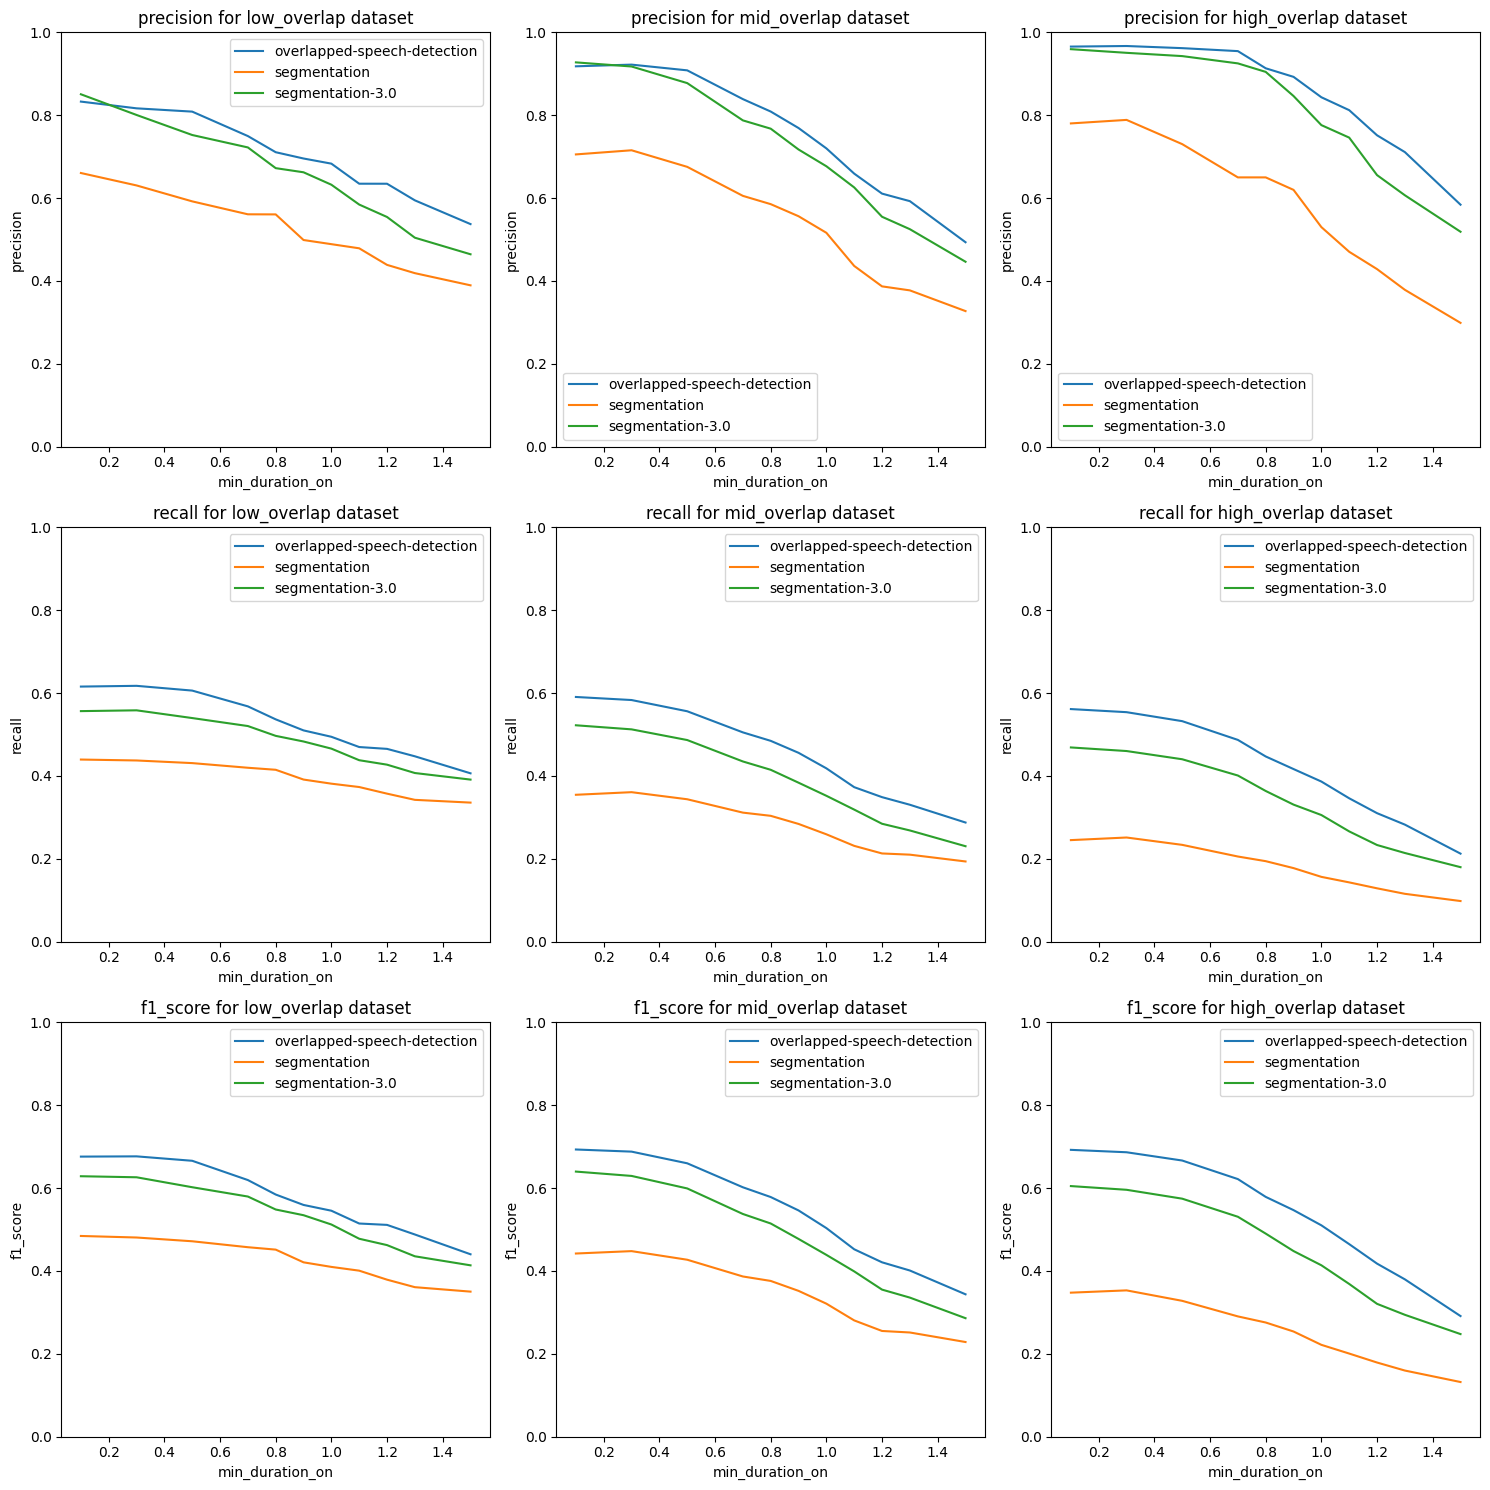

In [9]:
results = test_params(standard_args, "min_duration_on", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_on.json", "w"), indent=4)

100%|██████████| 11/11 [58:45<00:00, 320.46s/it]


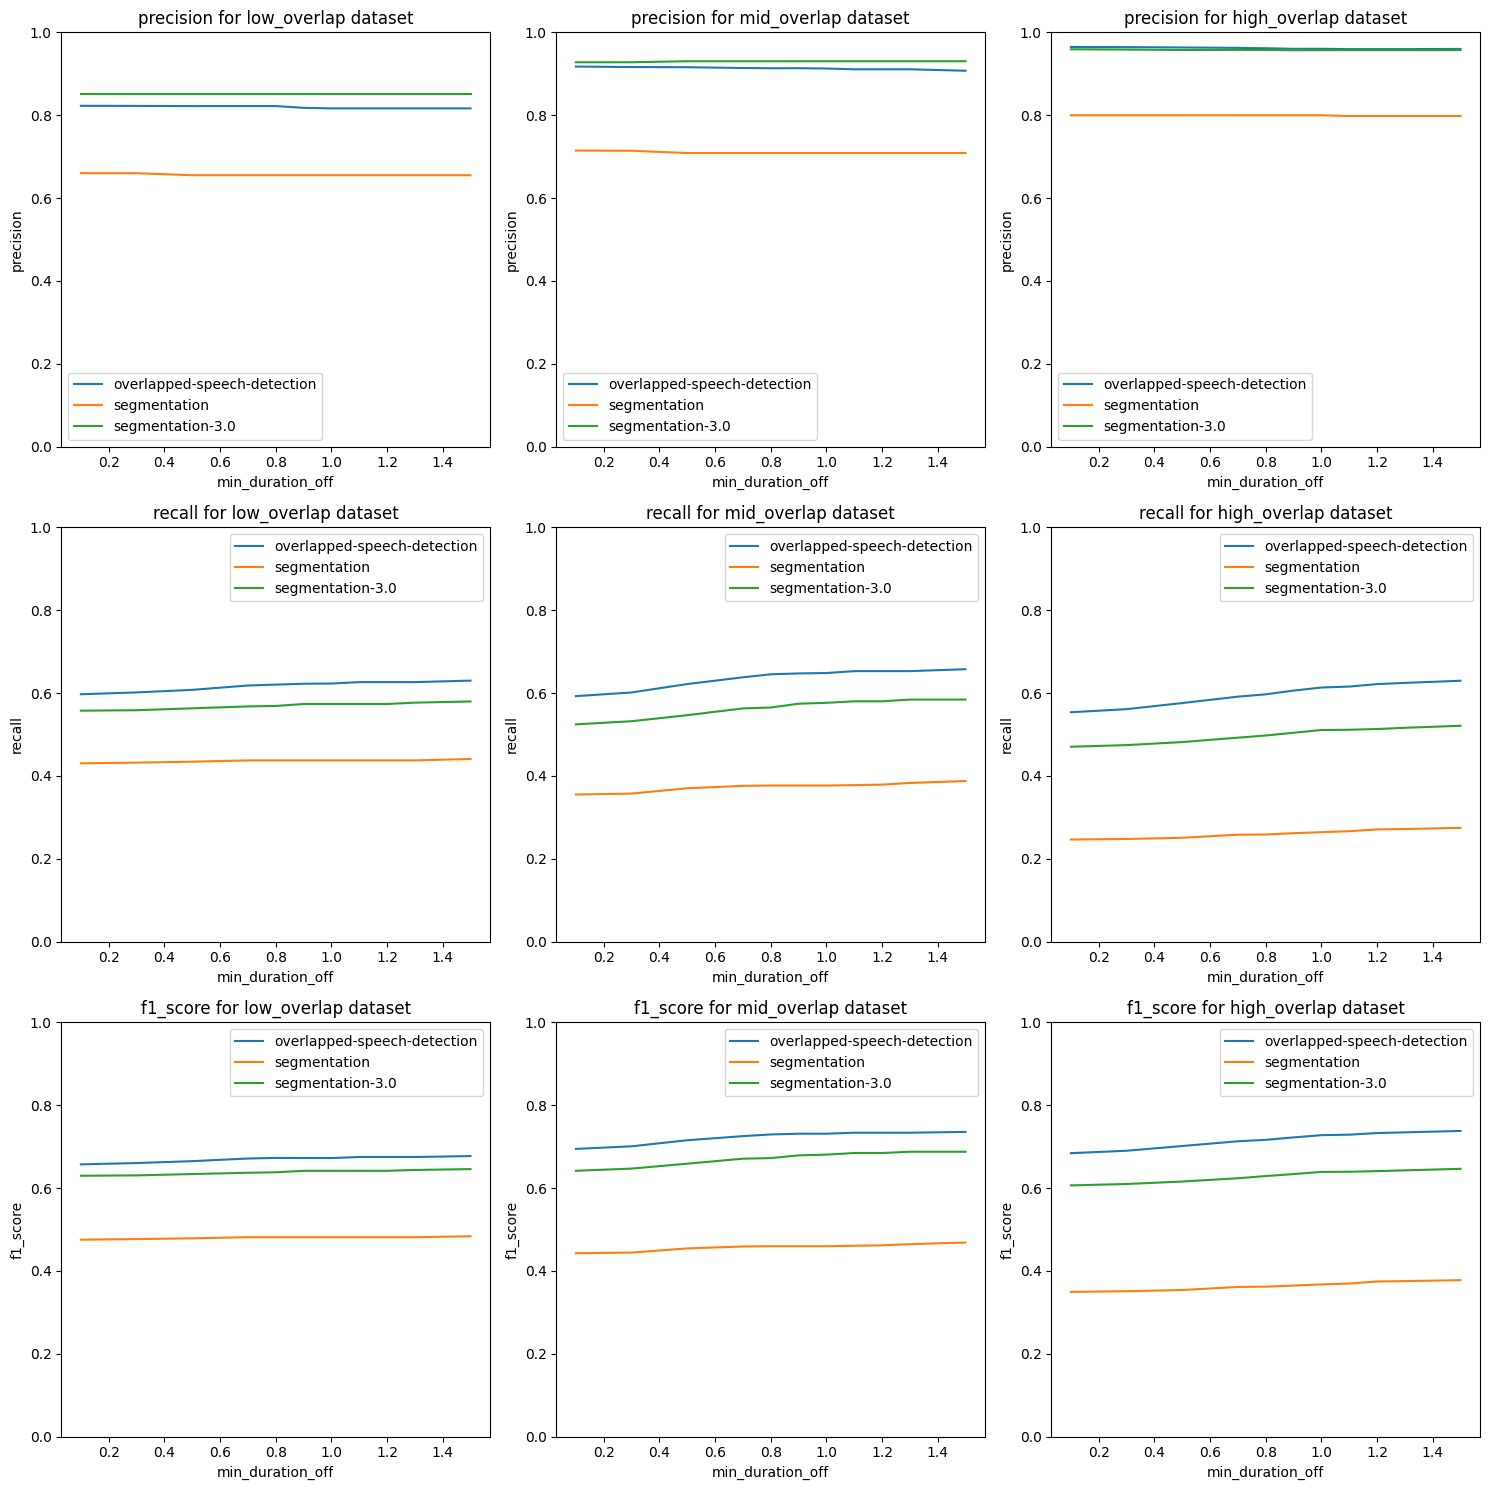

In [10]:
results = test_params(standard_args, "min_duration_off", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_off.json", "w"), indent=4)

In [ ]:
from matplotlib.lines import Line2D

def intersection_over_union(interval1: tuple[float, float], interval2: tuple[float, float]) -> float:
    start1, end1 = interval1
    start2, end2 = interval2
    intersection = max(0, min(end1, end2) - max(start1, start2))
    union = (end1 - start1) + (end2 - start2) - intersection
    return intersection / union if union > 0 else 0

def test_overlap_detection_hungarian(model, datasets, n=100):
    all_results = {}
    for dataset in datasets:
        overlap_df = pd.read_csv(f'data/dialogues/{dataset}/overlaps.csv')
        results = []

        for i in range(n):
            wav = librosa.load(f'data/dialogues/{dataset}/{i}.wav', sr=16000)[0]
            pred_overlaps = model({"waveform": torch.Tensor(wav).unsqueeze(0), "sample_rate": 16000})
            pred_overlaps = [[o.start, o.end] for o in pred_overlaps.itersegments()]
            overlaps = [(row['start'], row['end']) for _, row in overlap_df[overlap_df['sample_id'] == i].iterrows()]

            metrics = []

            ref_match = np.zeros((3, len(overlaps)))
            gen_match = np.zeros((3, len(pred_overlaps)))
            for i, overlap in enumerate(overlaps):
                for j, gen_overlap in enumerate(pred_overlaps):
                    iou = intersection_over_union(overlap, gen_overlap)
                    for k, thresh in enumerate([0.5, 0.75, 0.9]):
                        if iou >= thresh:
                            ref_match[k, i] = 1
                            gen_match[k, j] = 1

            for k, thresh in enumerate([0.5, 0.75, 0.9]):
                TP = sum(ref_match[k])
                FP = len(gen_match[k]) - TP
                FN = len(ref_match[k]) - TP
                prec = TP / (TP + FP) if (TP + FP) > 0 else 1 if FN == 0 else 0
                rec = TP / (TP + FN) if (TP + FN) > 0 else 1 if FP == 0 else 0
                f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
                metrics.extend([prec, rec, f1])

            results.append(metrics)

        all_results[dataset] = list(np.mean(results, axis=0))

    return all_results


def test_params_hungarian(args, param, values):
    datasets = ['low_overlap', 'mid_overlap', 'high_overlap']
    curr_model_names = ["overlapped-speech-detection", "segmentation", "segmentation-3.0"]
    if param == 'onset' or param == 'offset':
        curr_model_names = curr_model_names[:-1]
    results = {model: {dataset: [] for dataset in datasets} for model in curr_model_names}
    for value in tqdm(values):
        curr_args = args.copy()
        curr_args[param] = value

        model1.instantiate(curr_args)
        result = test_overlap_detection_hungarian(model1, datasets, n=100)
        for dataset, metric in result.items():
            results["overlapped-speech-detection"][dataset].append(metric)
        
        model2.instantiate(curr_args)
        result = test_overlap_detection_hungarian(model2, datasets, n=100)
        for dataset, metric in result.items():
            results["segmentation"][dataset].append(metric)

        if not (param == 'onset' or param == 'offset'):
            model3.instantiate({'min_duration_on': curr_args['min_duration_on'], 'min_duration_off': curr_args['min_duration_off']})
            result = test_overlap_detection_hungarian(model3, datasets, n=100)
            for dataset, metric in result.items():
                results["segmentation-3.0"][dataset].append(metric)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    metric_names = ["precision", "recall", "f1_score"]
    colors = ['blue', 'red', 'orange']

    color_legend = [
        Line2D([0], [0], color=color, lw=2, label=model)
        for model, color in zip(curr_model_names, colors)
    ]
    style_legend = [
        Line2D([0], [0], color='black', linestyle=':', label='IoU 50%'),
        Line2D([0], [0], color='black', linestyle='-', label='IoU 75%'),
        Line2D([0], [0], color='black', linestyle='--', label='IoU 90%'),
    ]

    for i, metric in enumerate(metric_names):
        for j, dataset in enumerate(datasets):
            axes[i, j].set_title(f"{metric} for {dataset} dataset")
            axes[i, j].set_xlabel(param)
            axes[i, j].set_ylabel(metric)
            axes[i, j].set_ylim(0, 1)
            for model, color in zip(curr_model_names, colors):
                for k, style in enumerate([':', '-', '--']):
                    axes[i, j].plot(values, [metrics[i + 3 * k] for metrics in results[model][dataset]], color=color, linestyle=style)
            axes[i, j].legend(handles=color_legend + style_legend, loc='lower right')

    plt.tight_layout()
    plt.show()
    return results


100%|██████████| 10/10 [42:09<00:00, 252.91s/it]


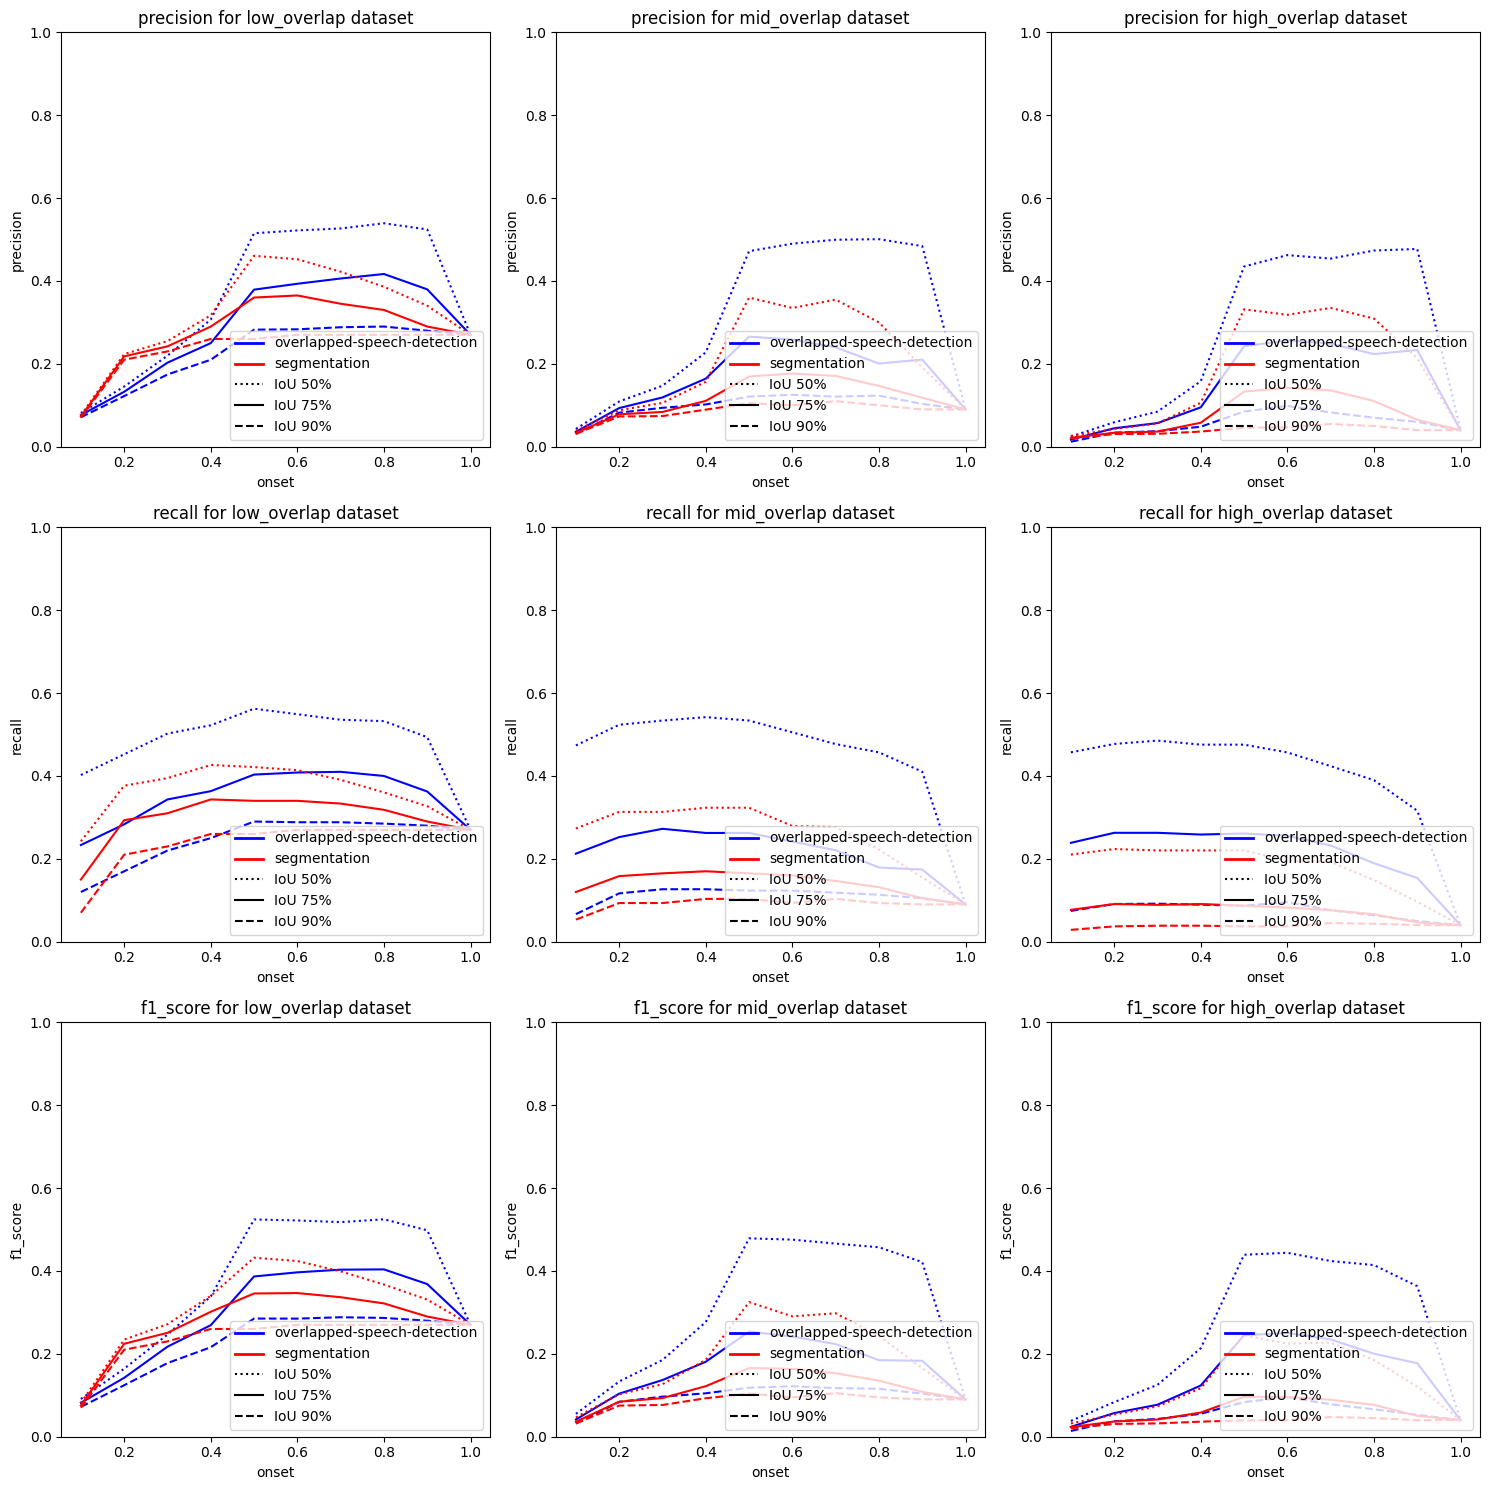

In [9]:
results = test_params_hungarian(standard_args, "onset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/onset_hungarian2.json", "w"), indent=4)

100%|██████████| 10/10 [43:49<00:00, 263.00s/it]


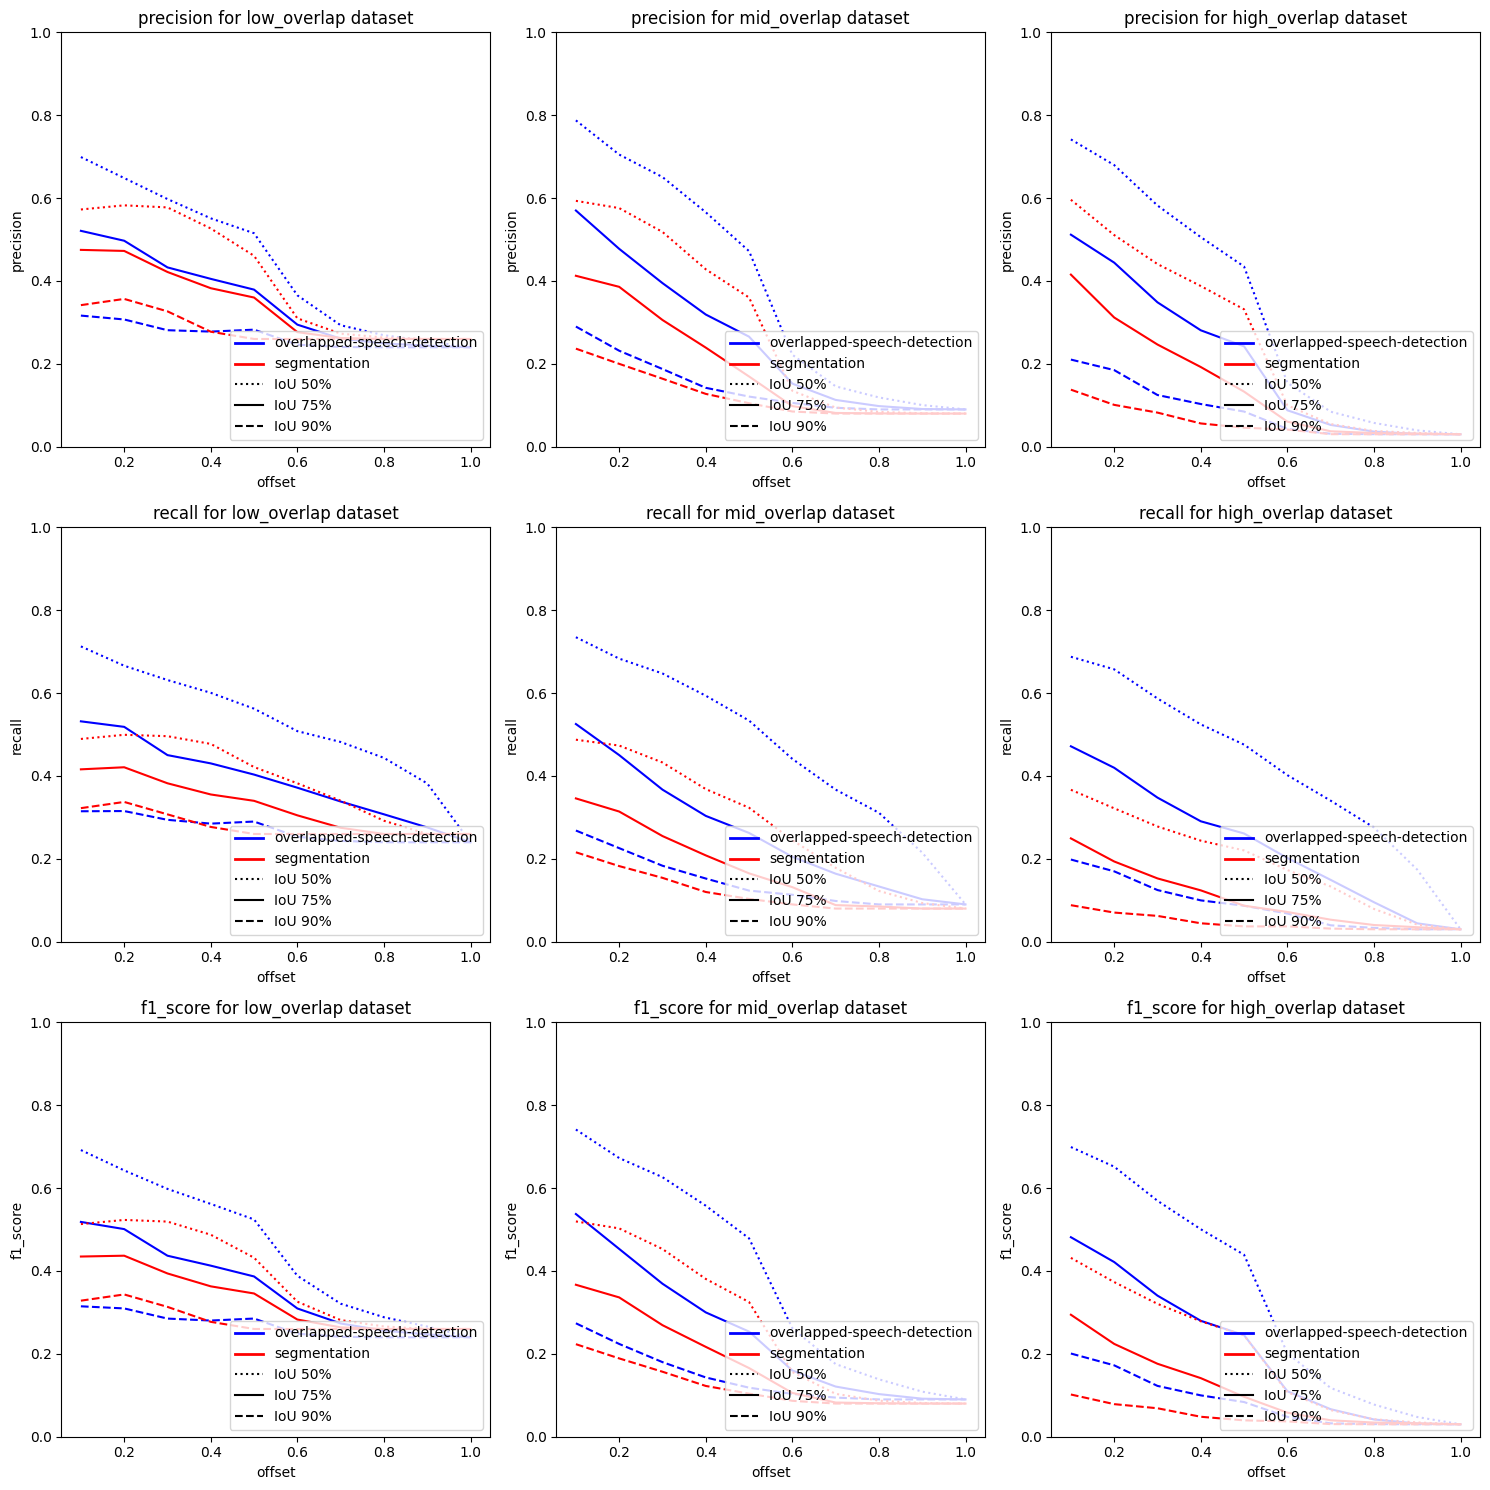

In [5]:
results = test_params_hungarian(standard_args, "offset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/offset_hungarian2.json", "w"), indent=4)

100%|██████████| 11/11 [1:15:52<00:00, 413.85s/it]


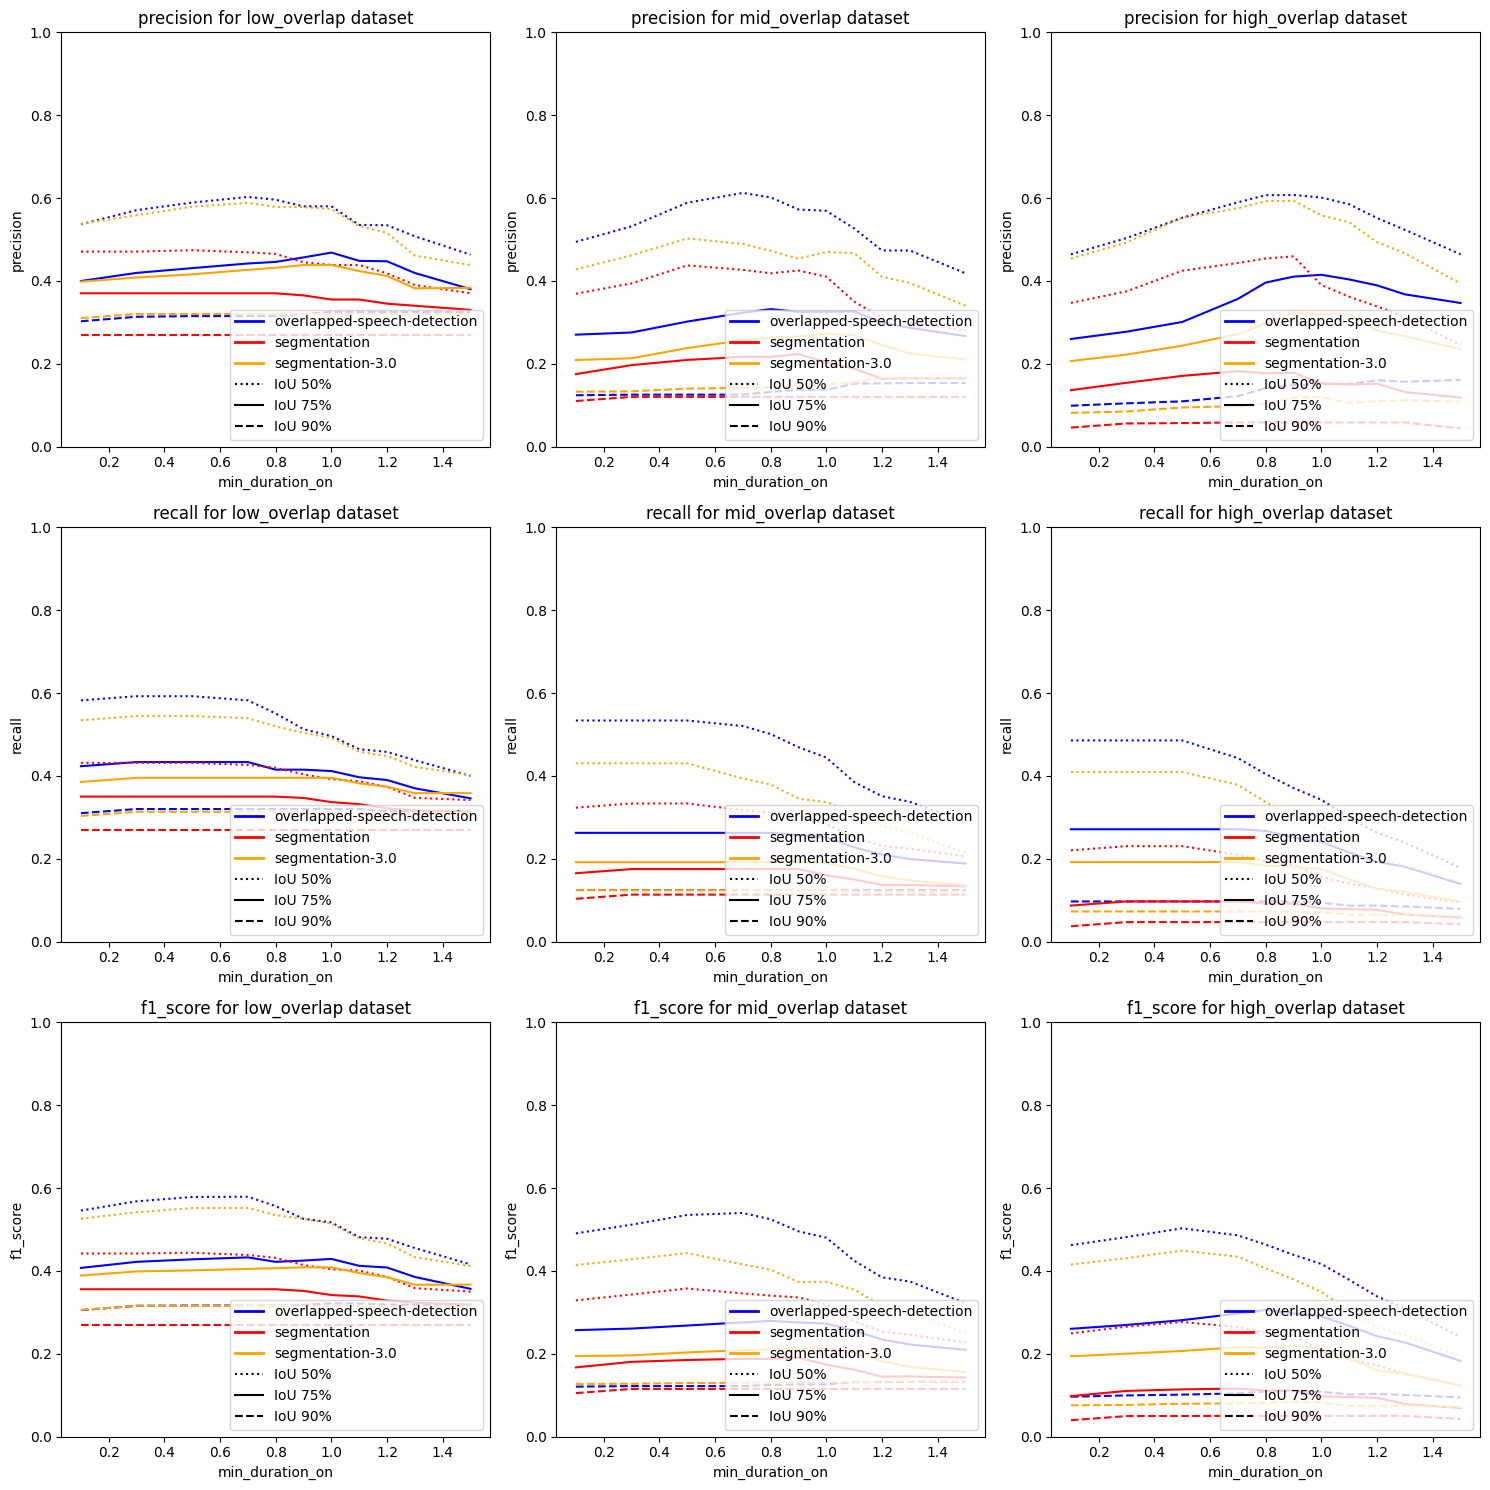

In [6]:
results = test_params_hungarian(standard_args, "min_duration_on", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_on_hungarian2.json", "w"), indent=4)

100%|██████████| 11/11 [1:05:02<00:00, 354.80s/it]


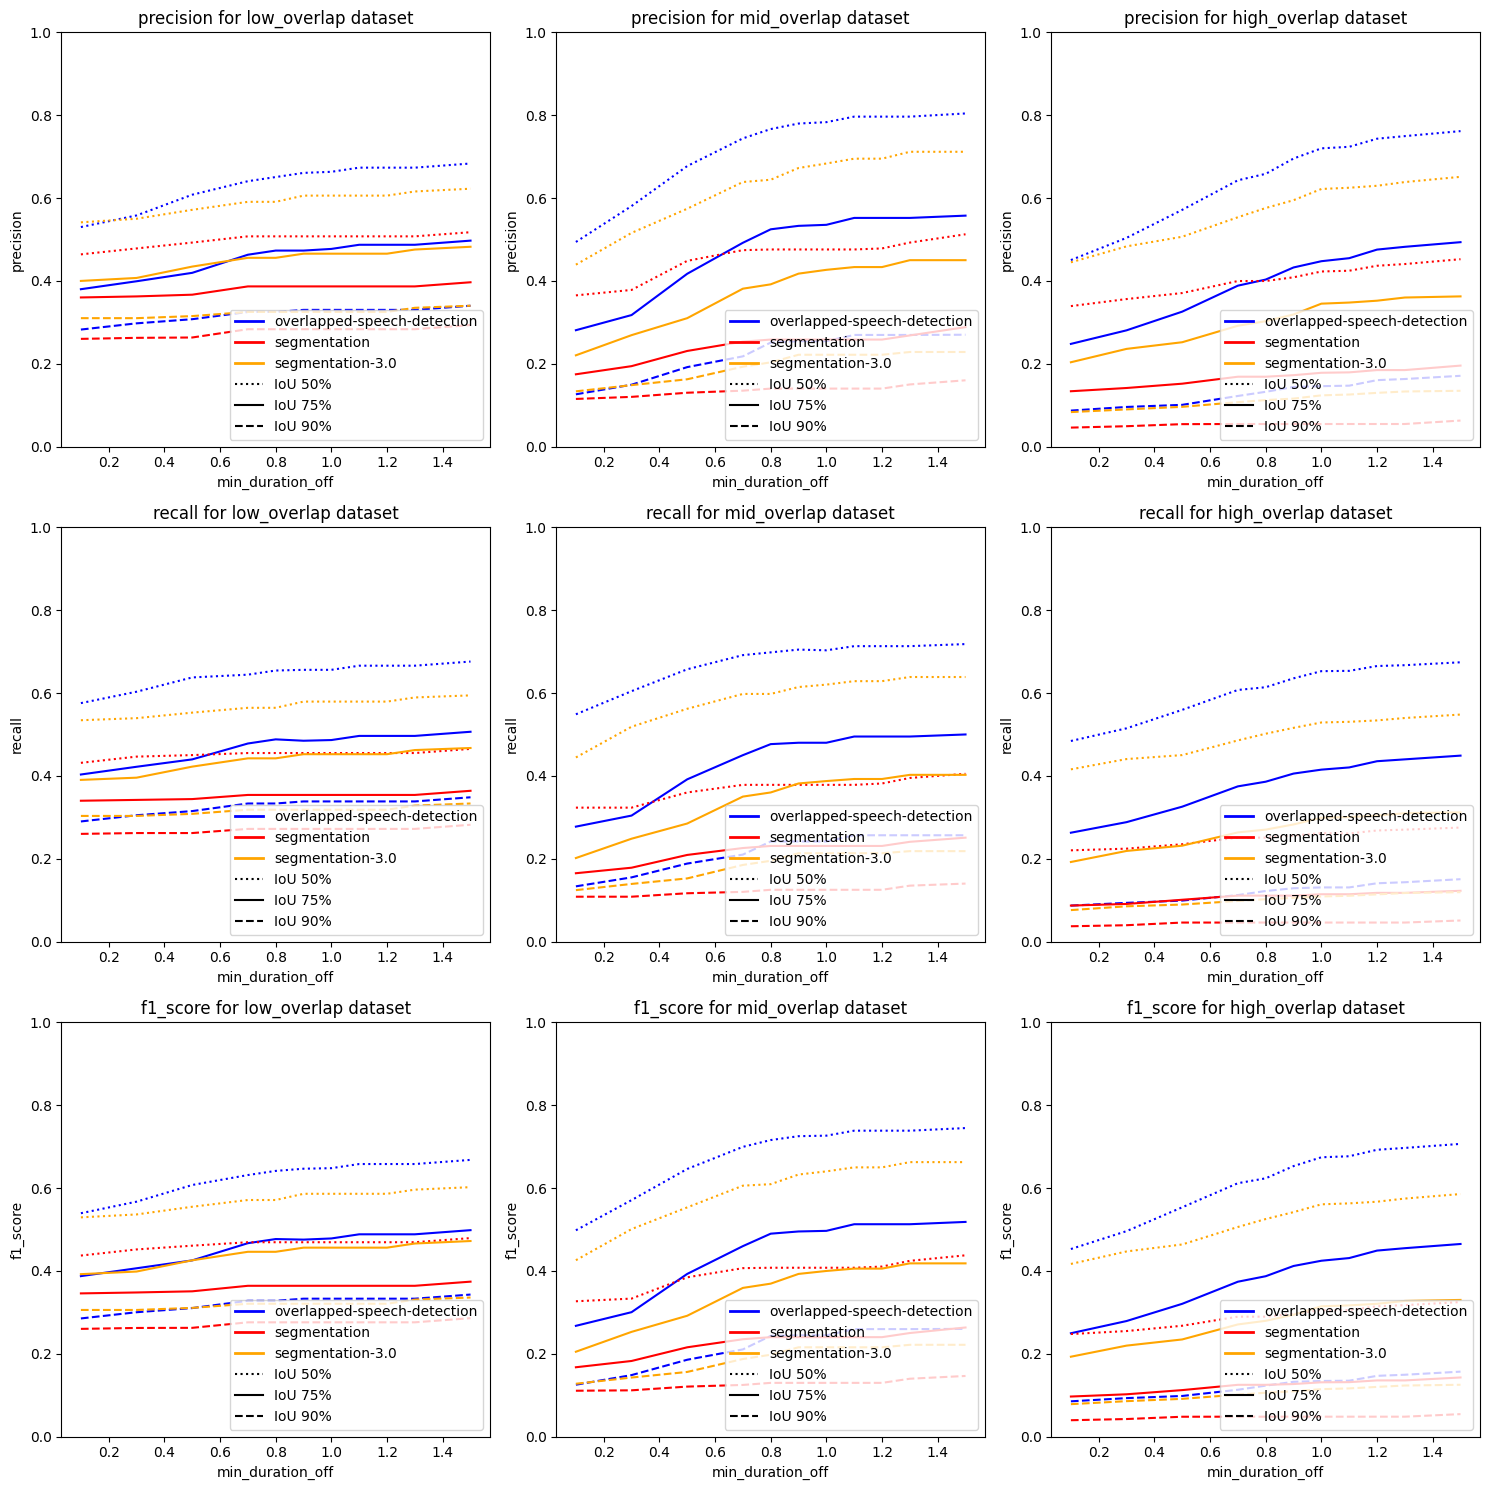

In [7]:
results = test_params_hungarian(standard_args, "min_duration_off", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_off_hungarian2.json", "w"), indent=4)

# Przeszukanie hiperparametrów

In [9]:
from itertools import product


def compute_overlap_times(ref_segments, pred_segments, total_time):
    events = []
    for start, end in ref_segments:
        events.append((start, 'start', 'ref'))
        events.append((end, 'end', 'ref'))
    for start, end in pred_segments:
        events.append((start, 'start', 'pred'))
        events.append((end, 'end', 'pred'))

    events.sort(key=lambda x: (x[0], x[1] == 'end'))

    prev_time = 0
    in_ref = False
    in_pred = False
    TP = FP = FN = TN = 0.0

    for time, kind, source in events:
        duration = time - prev_time

        if duration > 0:
            if in_ref and in_pred:
                TP += duration
            elif in_ref and not in_pred:
                FN += duration
            elif not in_ref and in_pred:
                FP += duration
            else:
                TN += duration

        if source == 'ref':
            in_ref = kind == 'start' if not in_ref else kind != 'end'
        elif source == 'pred':
            in_pred = kind == 'start' if not in_pred else kind != 'end'

        prev_time = time

    if prev_time < total_time:
        duration = total_time - prev_time
        if in_ref and in_pred:
            TP += duration
        elif in_ref and not in_pred:
            FN += duration
        elif not in_ref and in_pred:
            FP += duration
        else:
            TN += duration

    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}


def test_overlap_detection(model, n=100):
    overlap_df = pd.read_csv(f'data/dialogues/mid_overlap/overlaps.csv')
    results = []
    for i in range(n):
        wav = librosa.load(f'data/dialogues/mid_overlap/{i}.wav', sr=16000)[0]
        pred_overlaps = model({"waveform": torch.Tensor(wav).unsqueeze(0), "sample_rate": 16000})
        pred_overlaps = [[overlap.start, overlap.end] for overlap in pred_overlaps.itersegments()]
        overlaps = [(row['start'], row['end']) for _, row in overlap_df[overlap_df['sample_id'] == i].iterrows()]
        scores = compute_overlap_times(overlaps, pred_overlaps, len(wav) / 16000)
        prec = scores['TP'] / (scores['TP'] + scores['FP']) if (scores['TP'] + scores['FP']) > 0 else 1 if scores['FN'] == 0 else 0
        rec = scores['TP'] / (scores['TP'] + scores['FN']) if (scores['TP'] + scores['FN']) > 0 else 1 if scores['FP'] == 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        results.append([prec, rec, f1])
    results = list(np.mean(results, axis=0))
    return results


def search_args(args):
    results = []
    for onset, offset, min_duration_on, min_duration_off in tqdm(list(product(args['onset'], args['offset'], args['min_duration_on'], args['min_duration_off']))):
        model1.instantiate({
            "onset": onset,
            "offset": offset,
            "min_duration_on": min_duration_on,
            "min_duration_off": min_duration_off
        })
        result = test_overlap_detection(model1)
        results.append([onset, offset, min_duration_on, min_duration_off, *result])
    results = pd.DataFrame(results, columns=['onset', 'offset', 'min_duration_on', 'min_duration_off', 'precision', 'recall', 'f1_score'])
    return results

args = {
    "onset": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9],            # 6
    "offset": [0.1, 0.2, 0.3, 0.5],                     # 3
    "min_duration_on": [0.1, 0.2, 0.5],                 # 3
    "min_duration_off": [0.5, 0.8, 1, 1.2]              # 4
}
res_df = search_args(args)
res_df.to_csv('results/overlap_detection_param_search.csv')
res_df

100%|██████████| 288/288 [2:45:09<00:00, 34.41s/it]  


onset  offset  min_duration_on  min_duration_off  precision    recall  \
0      0.1     0.1              0.1               0.5   0.670313  0.802718   
1      0.1     0.1              0.1               0.8   0.658514  0.809629   
2      0.1     0.1              0.1               1.0   0.653361  0.817417   
3      0.1     0.1              0.1               1.2   0.647252  0.817754   
4      0.1     0.1              0.2               0.5   0.692929  0.822194   
..     ...     ...              ...               ...        ...       ...   
283    0.9     0.5              0.2               1.2   0.823853  0.478865   
284    0.9     0.5              0.5               0.5   0.813275  0.439865   
285    0.9     0.5              0.5               0.8   0.823853  0.459912   
286    0.9     0.5              0.5               1.0   0.823853  0.470758   
287    0.9     0.5              0.5               1.2   0.823853  0.477733   

     f1_score  
0    0.704934  
1    0.700000  
2    0.699109  
3    0.694651  
4    0.726293  
..        ...  
283  0.576654  
284  0.542863  
285  0.562366  
286  0.570739  
287  0.575793  

[288 rows x 7 columns]

In [10]:
max_precision = res_df['precision'].max()
max_recall = res_df['recall'].max()
max_f1 = res_df['f1_score'].max()

res_df[
    (res_df['precision'] == max_precision) |
    (res_df['recall'] == max_recall) |
    (res_df['f1_score'] == max_f1)
]

onset  offset  min_duration_on  min_duration_off  precision    recall  \
11     0.1     0.1              0.5               1.2   0.699416  0.856888   
68     0.2     0.2              0.5               0.5   0.878968  0.796402   
136    0.4     0.5              0.2               0.5   0.920708  0.670253   

     f1_score  
11   0.741559  
68   0.810685  
136  0.747937

# Wizualizacja wpływu hiperparametrów na zoptymalizowanych watrościach

In [4]:
best_args = {
    'onset': 0.2,
    'offset': 0.2,
    'min_duration_on': 0.5,
    'min_duration_off': 0.5
}

100%|██████████| 10/10 [36:50<00:00, 221.05s/it]


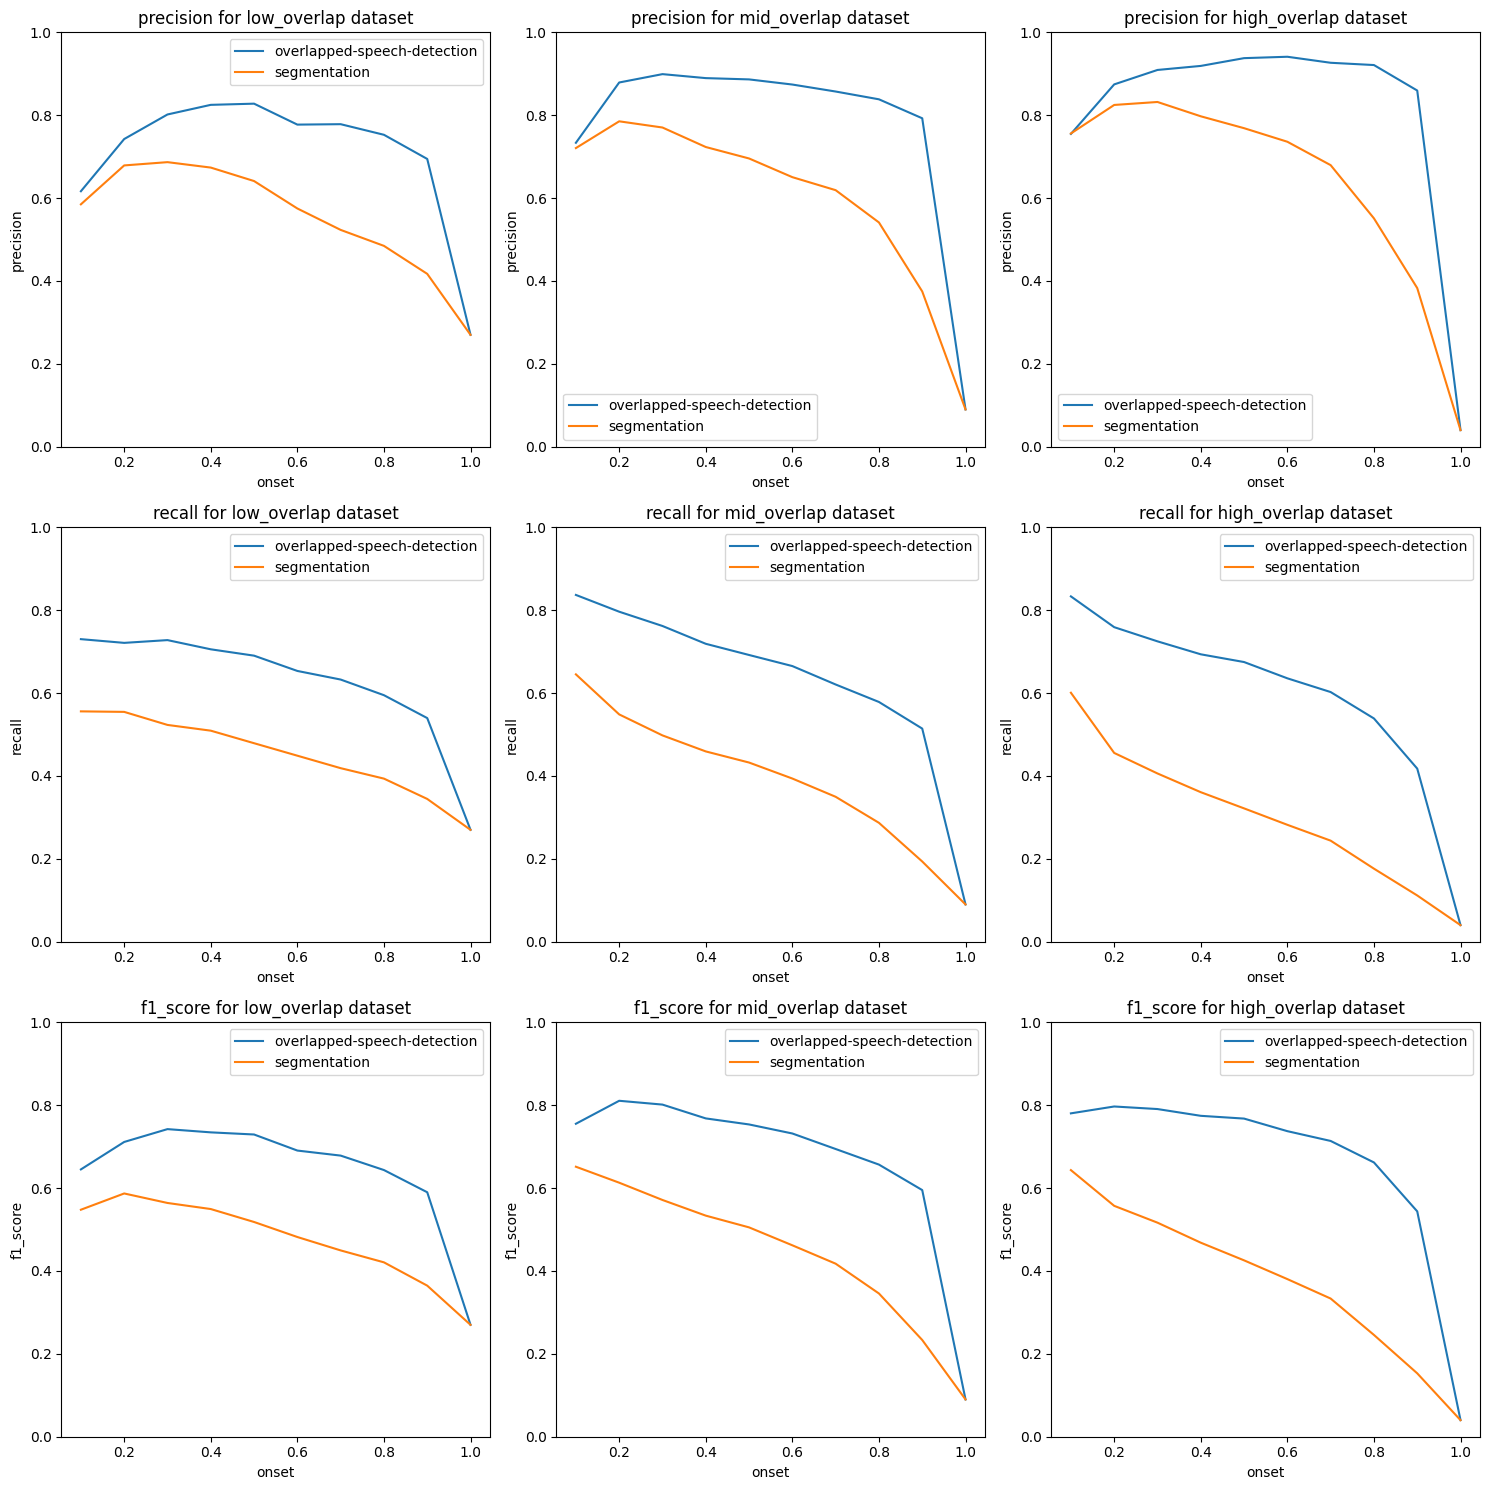

In [14]:
results = test_params(best_args, "onset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/onset_best.json", "w"), indent=4)

100%|██████████| 10/10 [36:25<00:00, 218.56s/it]


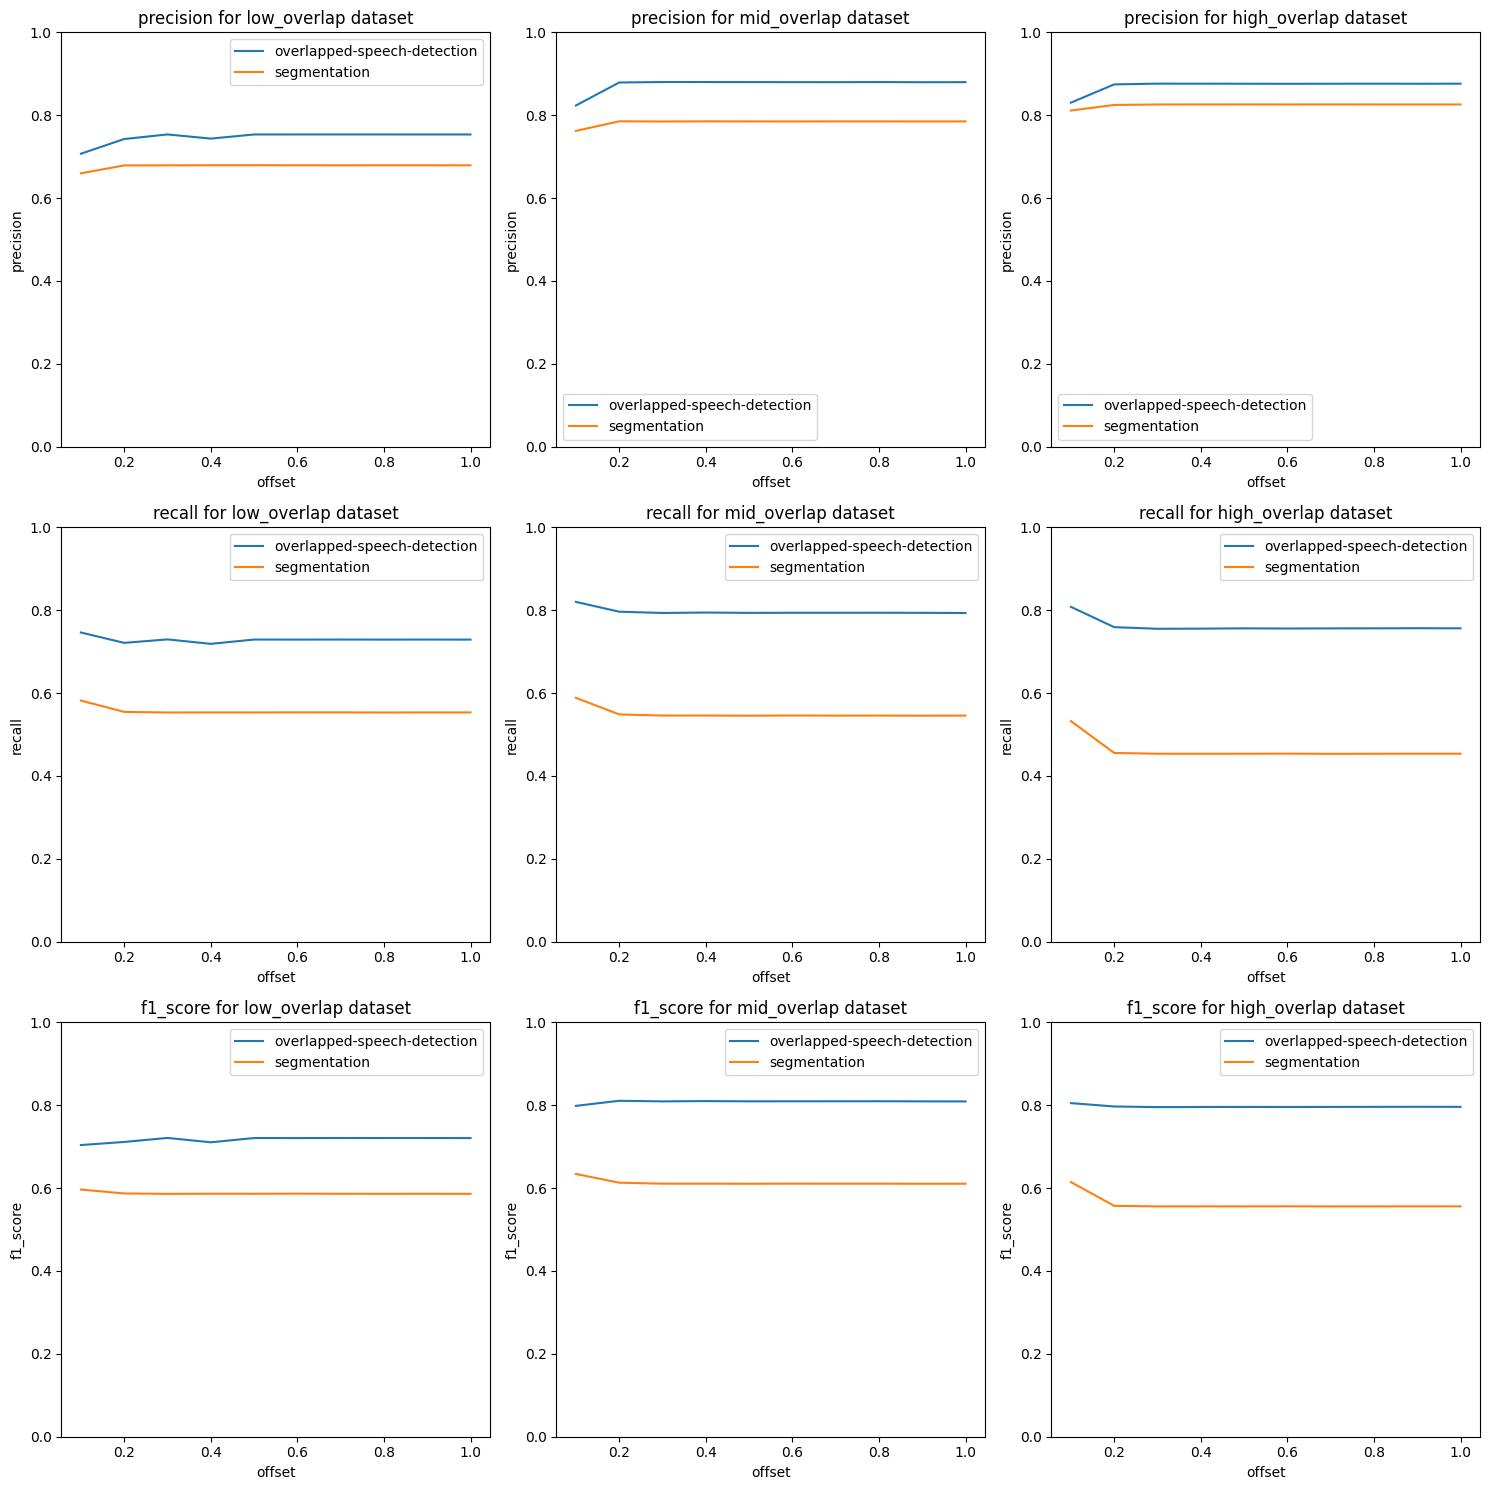

In [15]:
results = test_params(best_args, "offset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/offset_best.json", "w"), indent=4)

100%|██████████| 11/11 [58:23<00:00, 318.48s/it]


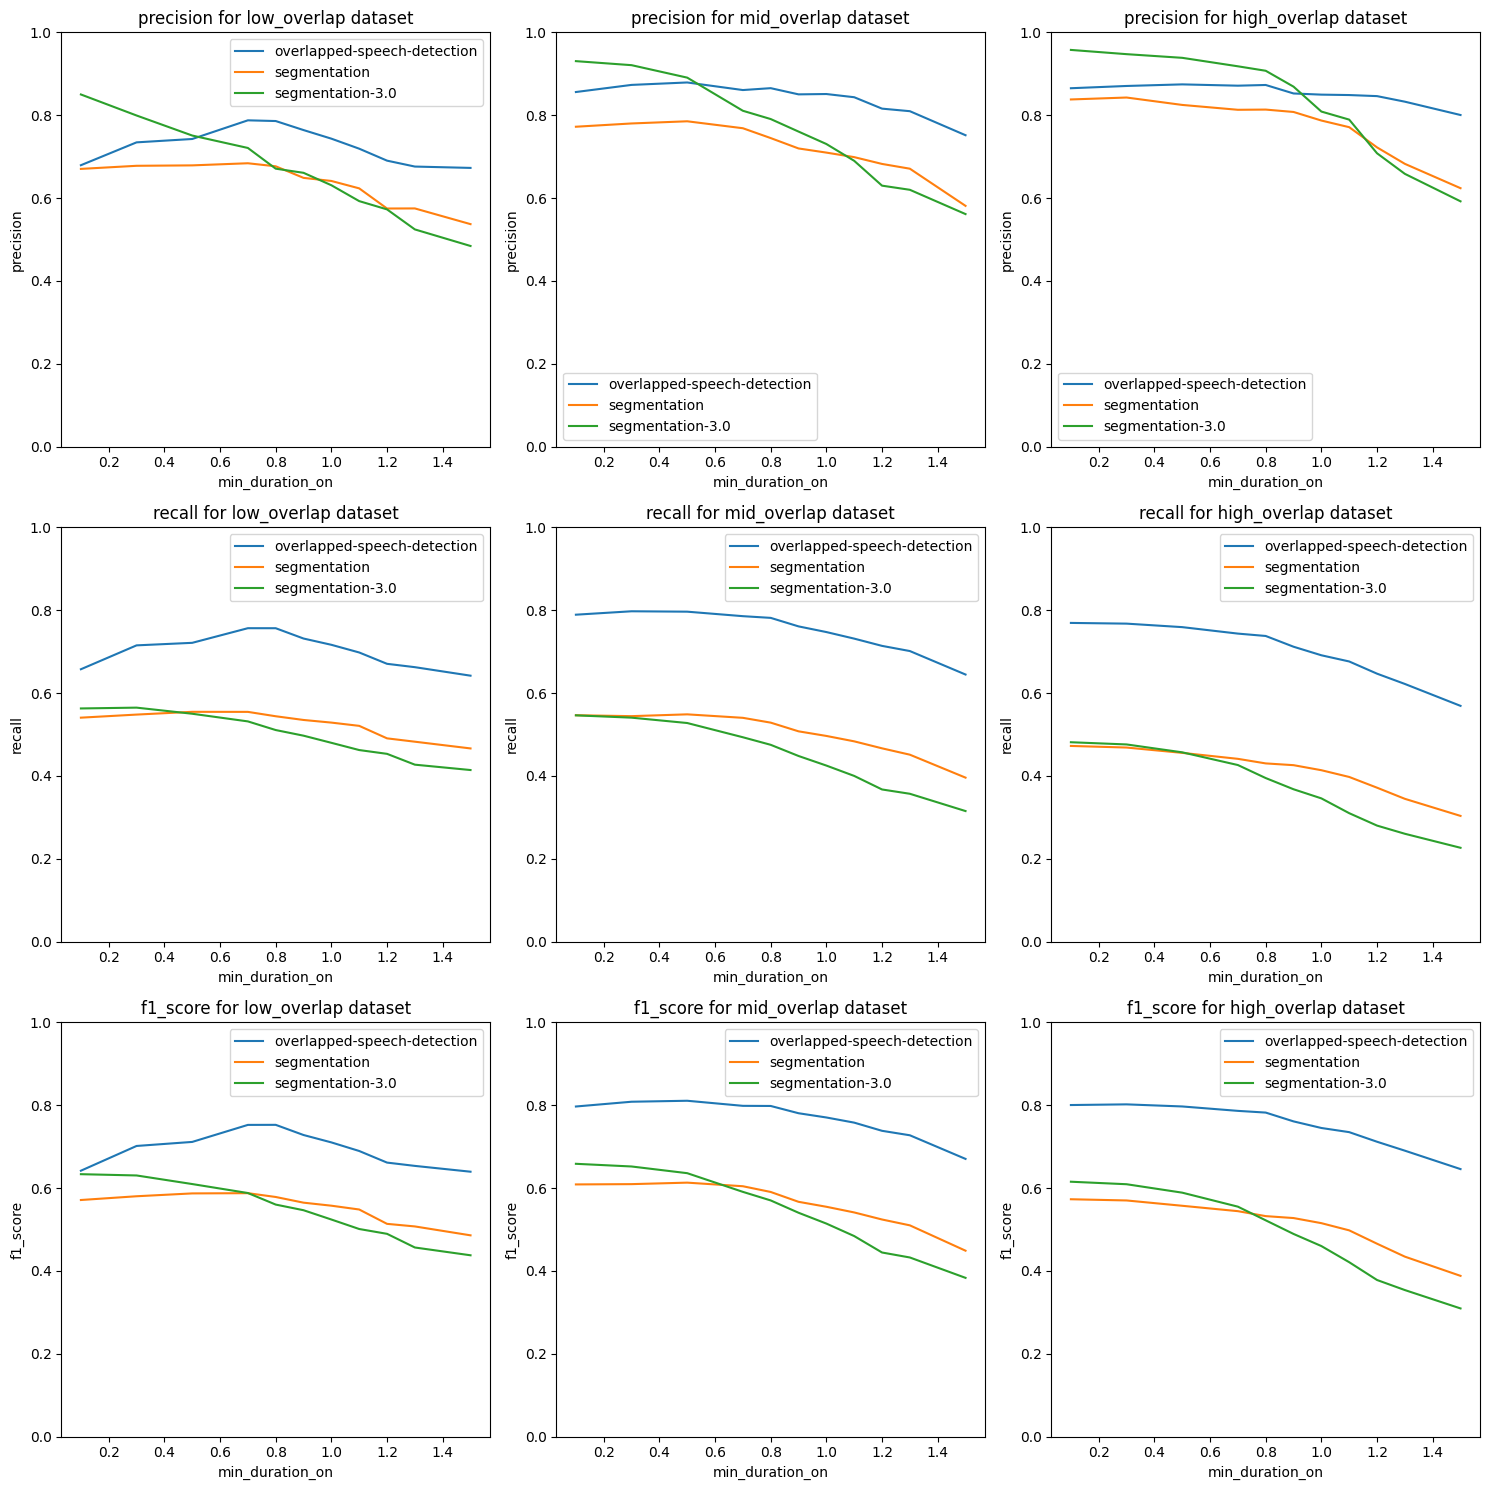

In [16]:
results = test_params(best_args, "min_duration_on", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_on_best.json", "w"), indent=4)

100%|██████████| 11/11 [58:28<00:00, 318.99s/it]


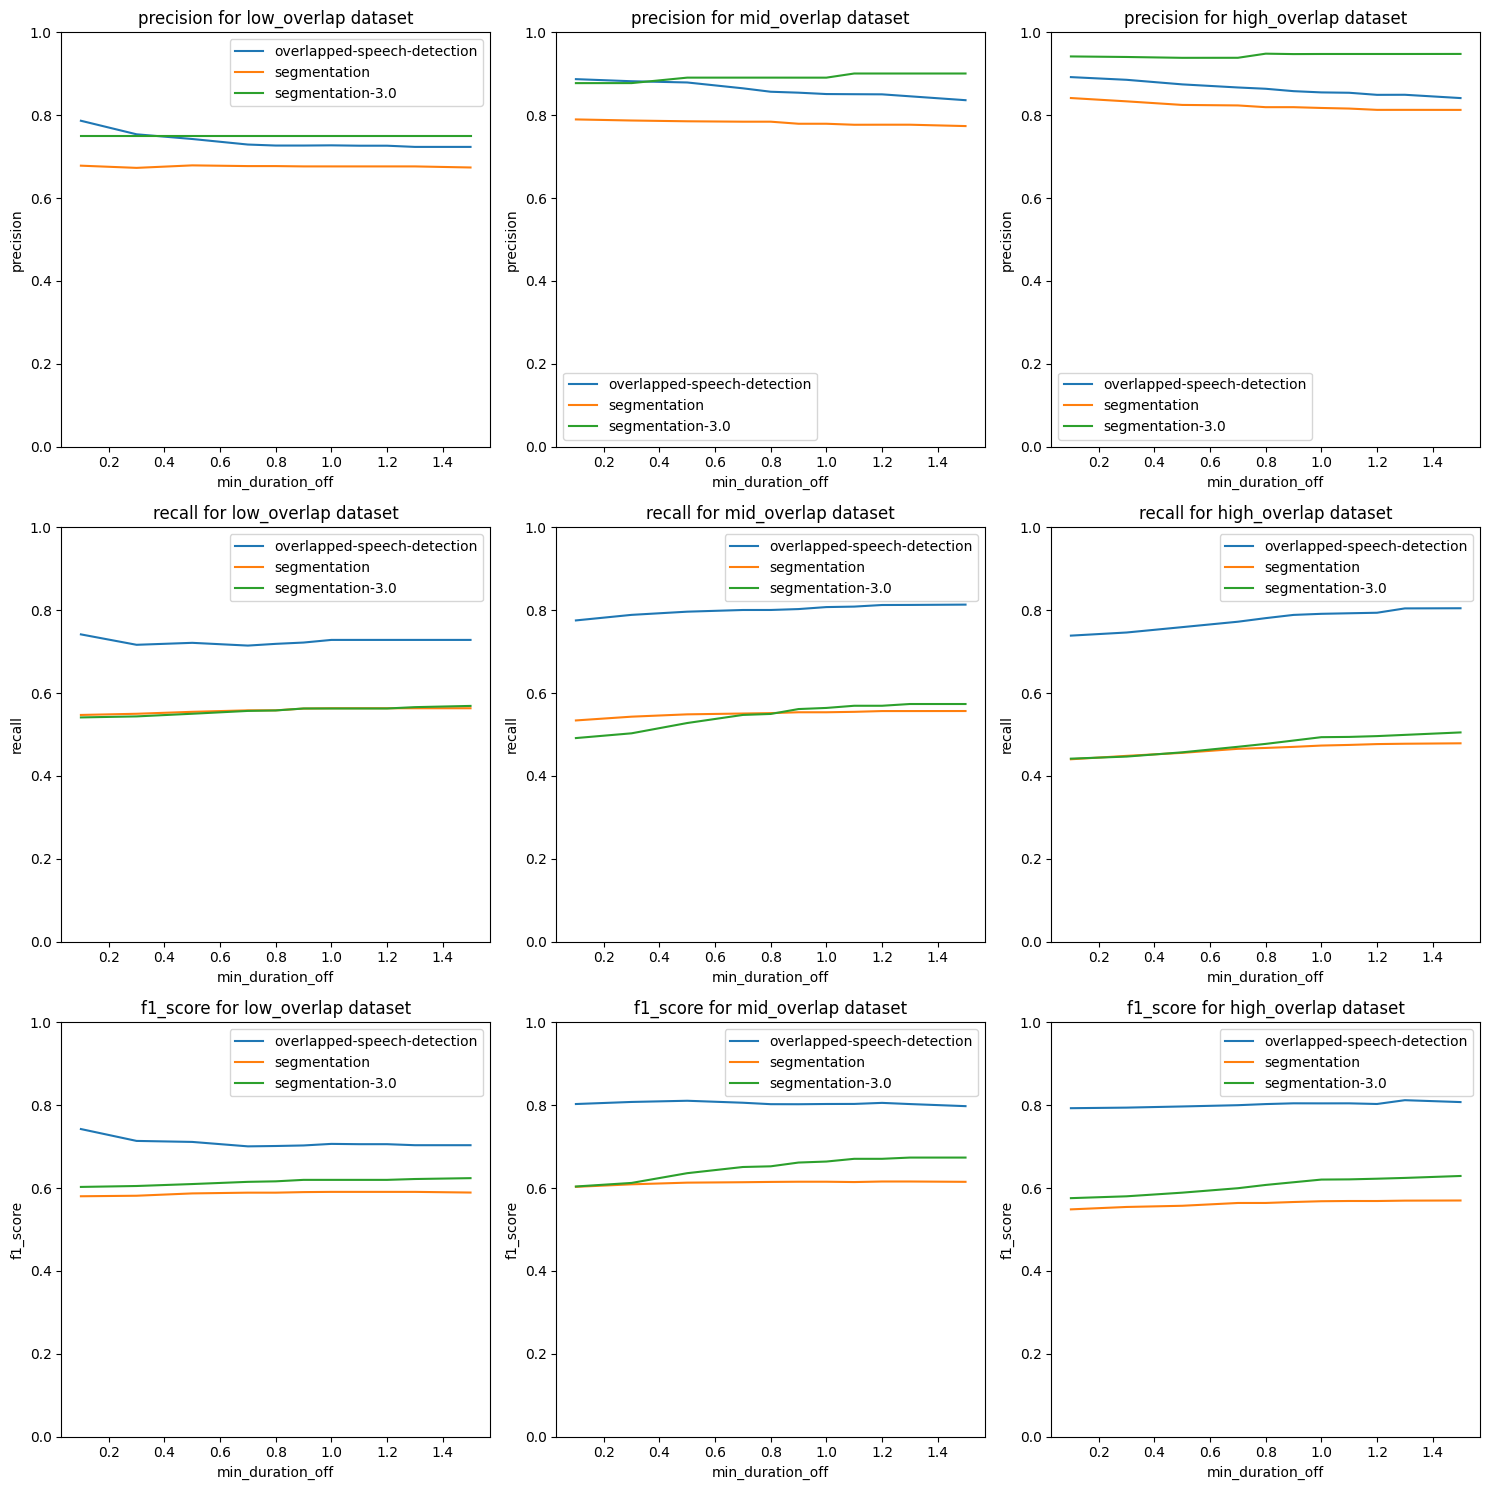

In [17]:
results = test_params(best_args, "min_duration_off", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_off_best.json", "w"), indent=4)

100%|██████████| 10/10 [34:02<00:00, 204.20s/it]


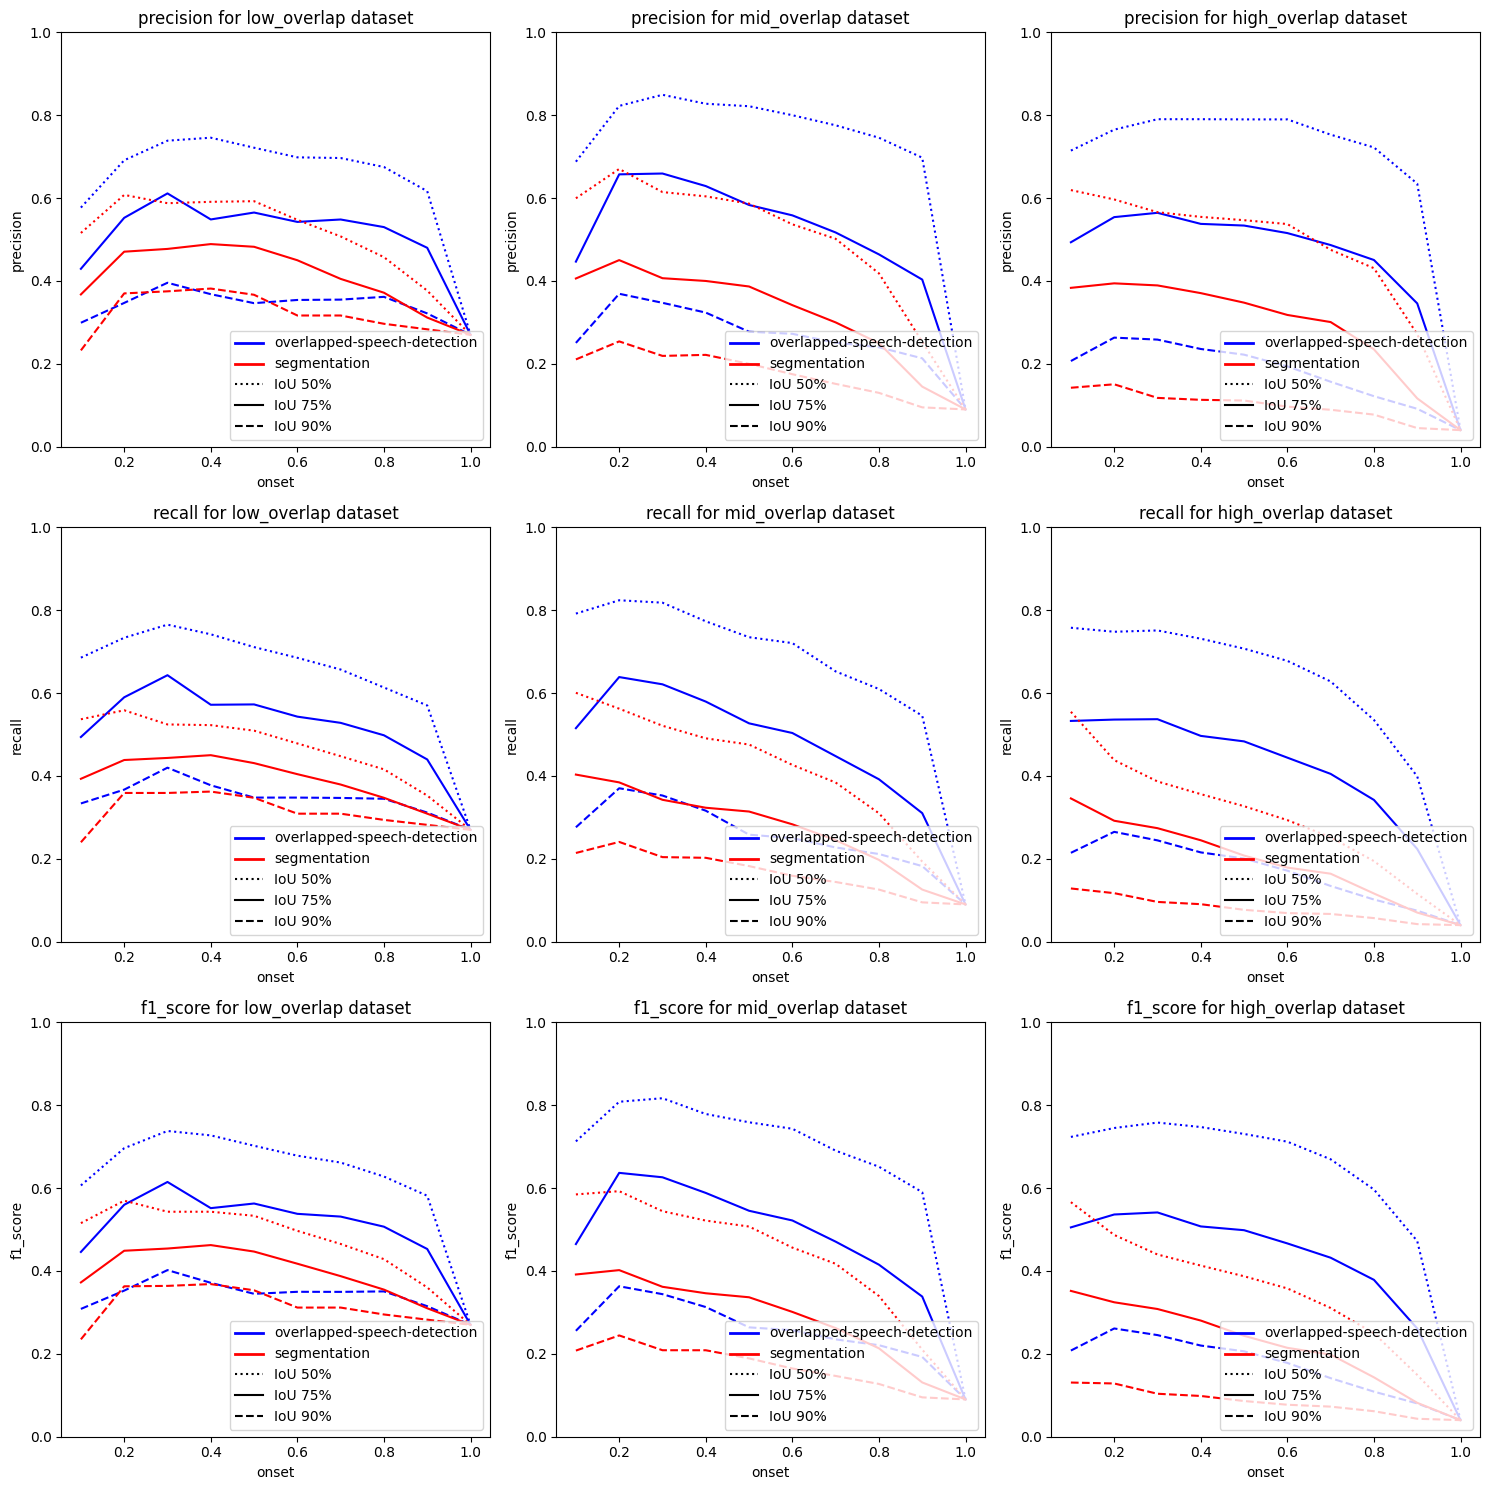

In [5]:
results = test_params_hungarian(best_args, "onset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/onset_hungarian2_best.json", "w"), indent=4)

100%|██████████| 10/10 [35:58<00:00, 215.85s/it]


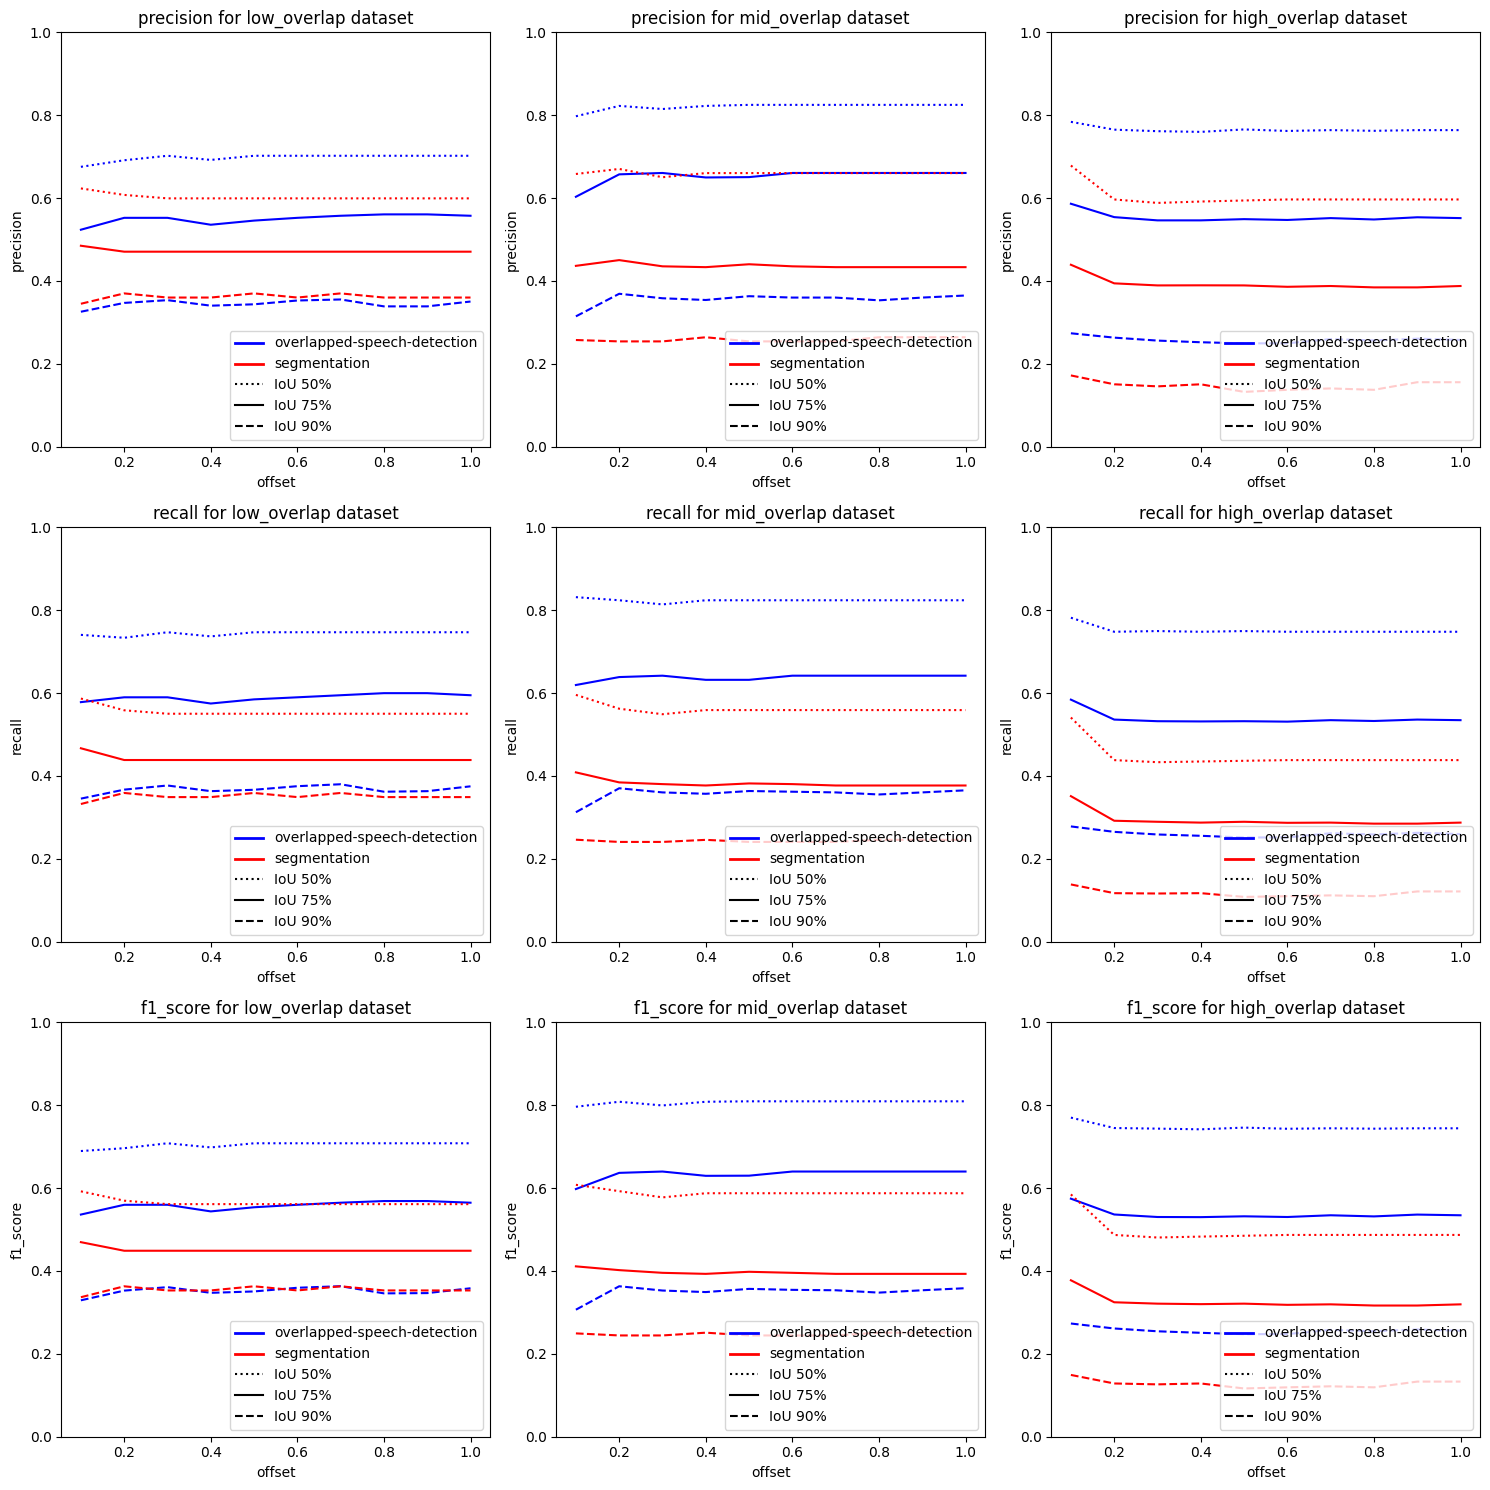

In [6]:
results = test_params_hungarian(best_args, "offset", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
json.dump(results, open("results/offset_hungarian2_best.json", "w"), indent=4)

100%|██████████| 11/11 [59:46<00:00, 326.03s/it]


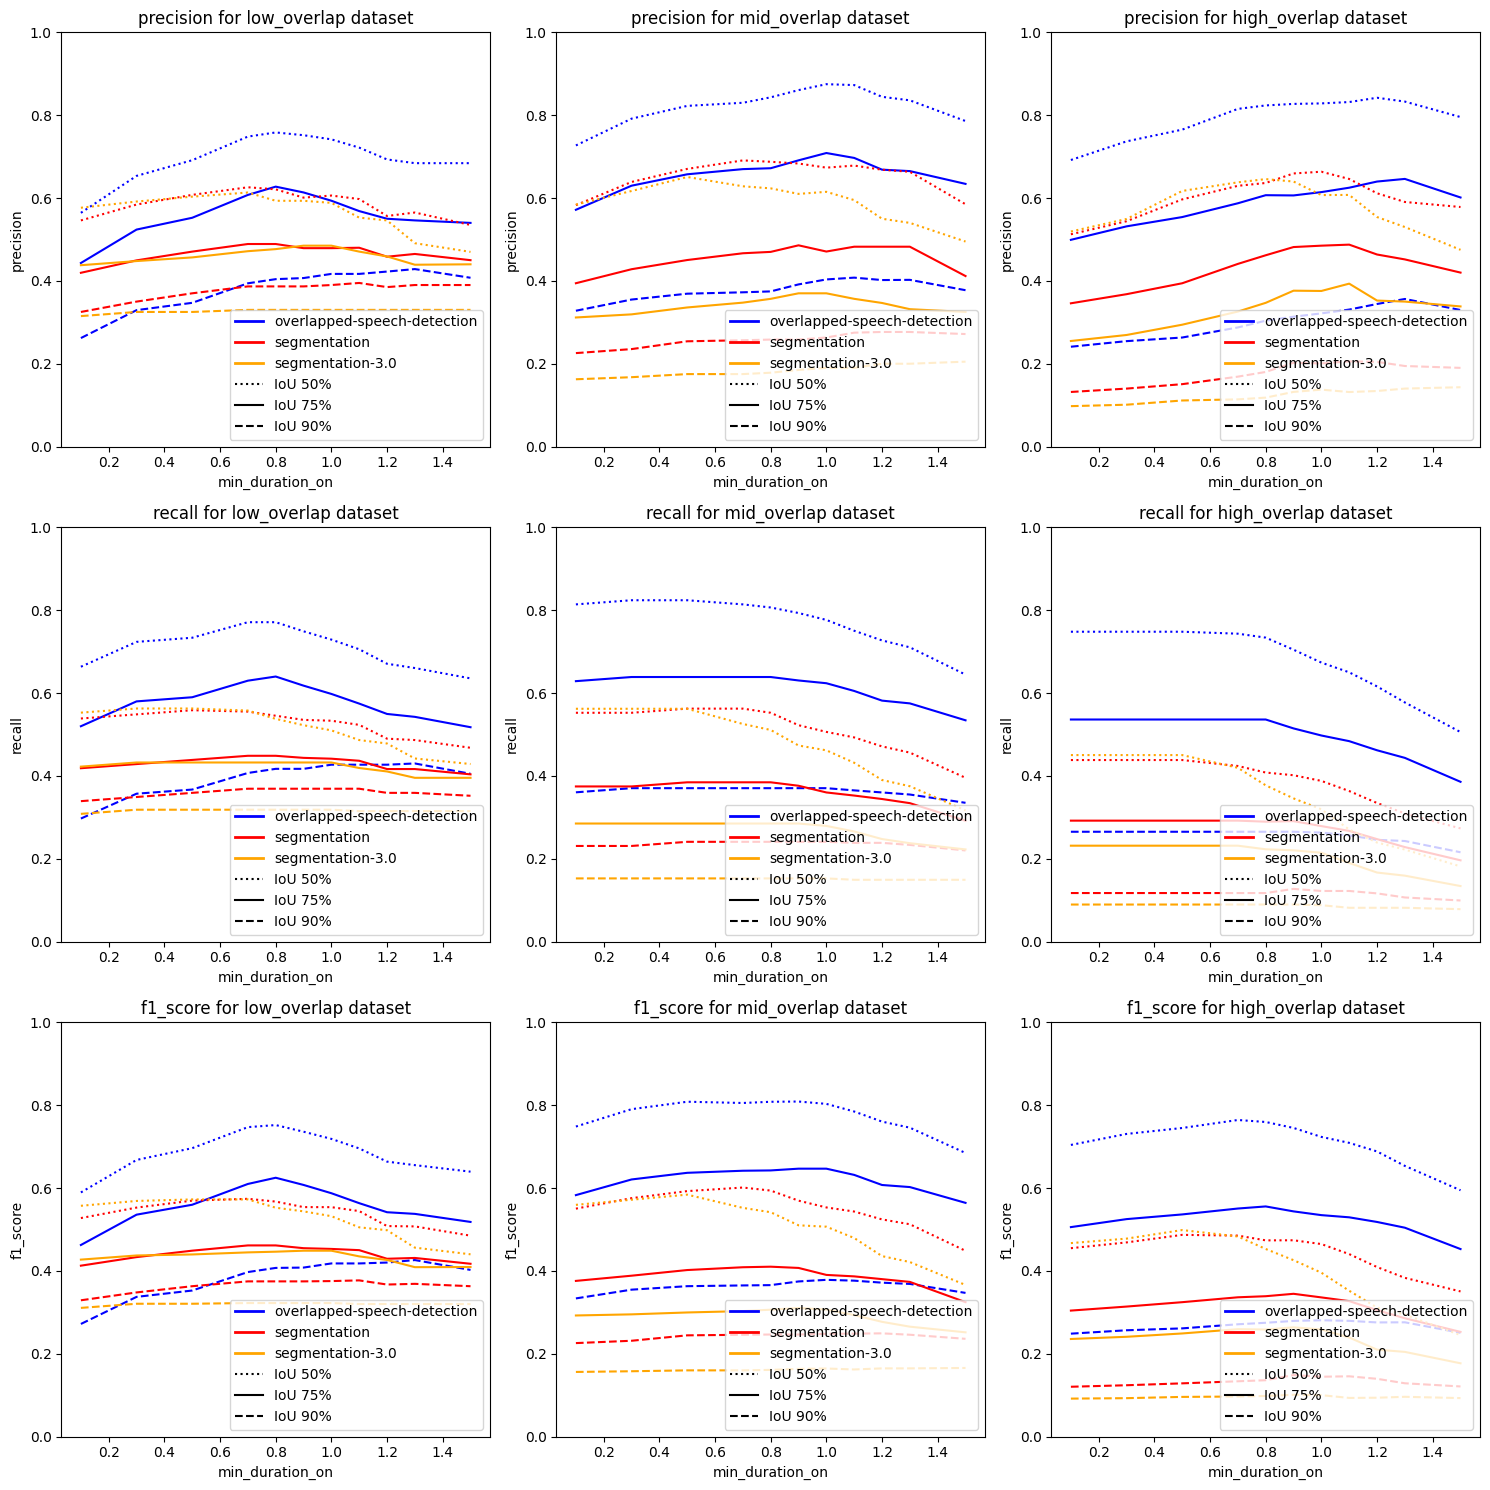

In [7]:
results = test_params_hungarian(best_args, "min_duration_on", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_on_hungarian2_best.json", "w"), indent=4)

100%|██████████| 11/11 [1:00:25<00:00, 329.56s/it]


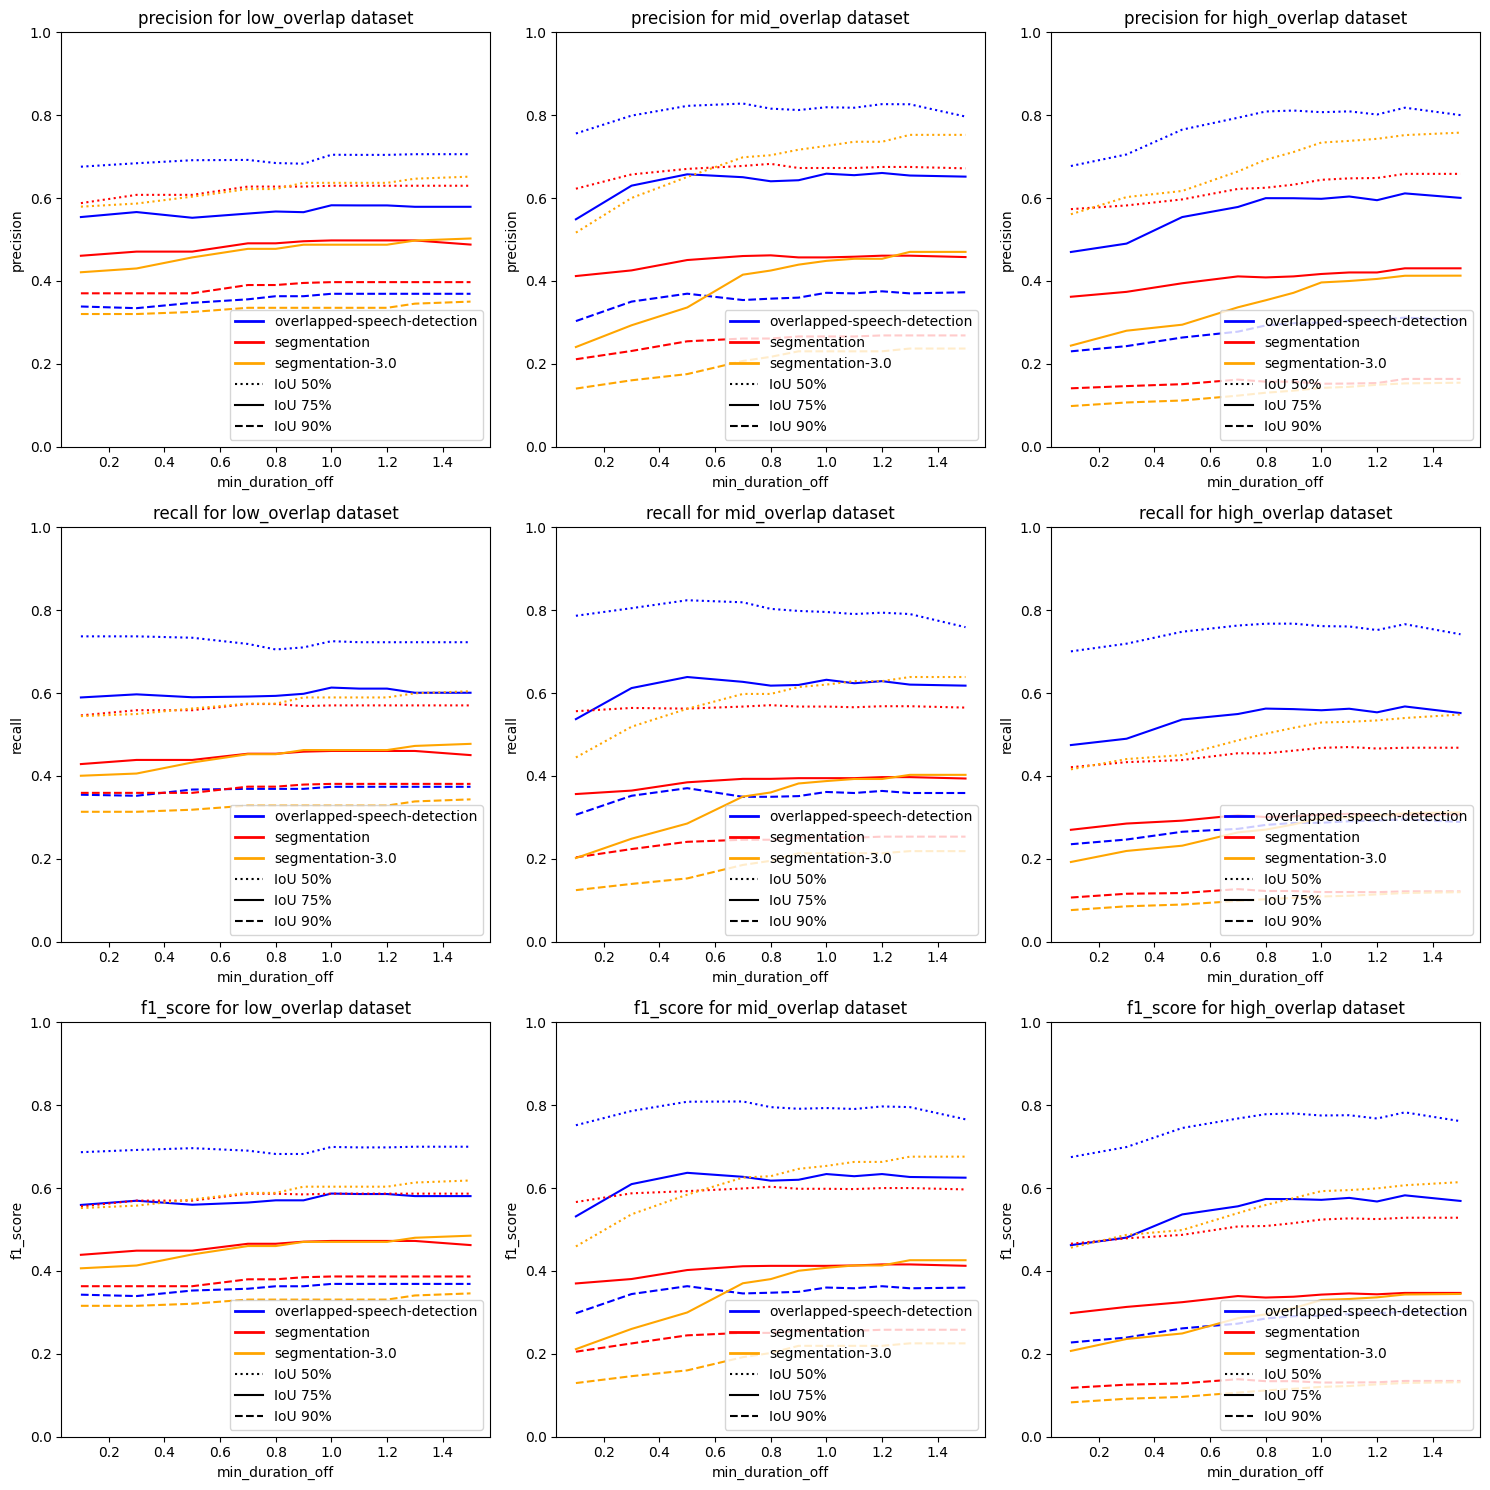

In [8]:
results = test_params_hungarian(best_args, "min_duration_off", [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5])
json.dump(results, open("results/min_duration_off_hungarian2_best.json", "w"), indent=4)